In [1]:
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, recall_score, precision_score
import matplotlib.ticker as mtick
from datetime import datetime
# set view options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)

%matplotlib inline
sns.set(font_scale=2)

# Section 1: Data load

In [2]:
data = []
## line delimited json file - load one at a time - convert to padas df 
with open('transactions.txt', 'r') as f:
    for line in f:
        data.append(json.loads(line))
df = pd.DataFrame.from_records(data)
print(df.shape)
print(df.columns)
df.head()

(641914, 29)
Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'echoBuffer', 'currentBalance',
       'merchantCity', 'merchantState', 'merchantZip', 'cardPresent',
       'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch'],
      dtype='object')


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,,0.00,,,,False,,,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,,111.33,,,,False,,,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,,136.08,,,,False,,,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,,323.48,,,,False,,,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,,550.82,,,,False,,,False


In [3]:
#is account id the same as customer id?
sum(df['accountNumber']==df['customerId']) == df.shape[0]
# accountnumber and customerid are the same for this dataset

True

In [4]:
# num of custs 
print(f"Number of customers : {df['accountNumber'].nunique()}")

# num of cards - create unique card identifier
df['CC_ID'] = df['cardLast4Digits'].astype(str)+df['accountNumber'].astype(str)
print(f"Number of  cards: {df['CC_ID'].nunique()}")

# Fraud rate for the transaction book
print(f"Fraud rate for the transaction book : {np.round(100*(df['isFraud']==1).sum()/df.shape[0],2)}%")

Number of customers : 5000
Number of  cards: 7268
Fraud rate for the transaction book : 1.76%


# Section 2: Data Dive

In [5]:
# data types 
df.dtypes

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
isFraud                        bool
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd            

In [6]:
# unary variables
#pd.concat([df.nunique(), df.isna().sum()], axis=1).reset_index()
df.nunique()[df.nunique() == 1]

echoBuffer          1
merchantCity        1
merchantState       1
merchantZip         1
posOnPremises       1
recurringAuthInd    1
dtype: int64

In [7]:
# but first lets look at the cols with 1 unique value
unary_cols = ['echoBuffer', 'merchantCity', 'merchantState'
              , 'merchantZip', 'posOnPremises', 'recurringAuthInd']
for col in unary_cols:
    print(df[col].unique())

['']
['']
['']
['']
['']
['']


In [8]:
# drop these 
df.drop(unary_cols, axis = 1, inplace = True)

In [9]:
# convert bool cols to ints
for bool_col in ['cardPresent','isFraud', 'expirationDateKeyInMatch']:
    df[bool_col] = df[bool_col].astype(int)

In [10]:
# some variable conversions to appropriate types
# date vars first
df[['transactionDate', 'transactionTime']] = df['transactionDateTime'].str.split('T', expand = True)
for date_col in ['transactionDate','accountOpenDate','dateOfLastAddressChange']:
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
df['transactionTime'] = pd.to_datetime(df['transactionTime'], format = '%H:%M:%S')
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format = '%m/%Y')
df['transactionDateTime'] = df['transactionDateTime'].replace('T',' ')
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format = '%Y-%m-%d %H:%M:%S')
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime
0,733493772,733493772,5000.0,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,01,rideshare,2020-04-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,0.00,0,0,9184733493772,2016-01-08,1900-01-01 19:04:50
1,733493772,733493772,5000.0,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,01,rideshare,2023-06-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,111.33,0,0,9184733493772,2016-01-09,1900-01-01 22:32:39
2,733493772,733493772,5000.0,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,01,rideshare,2027-12-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,136.08,0,0,9184733493772,2016-01-11,1900-01-01 13:36:55
3,733493772,733493772,5000.0,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,02,01,rideshare,2029-09-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,323.48,0,0,9184733493772,2016-01-11,1900-01-01 22:47:46
4,733493772,733493772,5000.0,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,02,01,rideshare,2024-10-01,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,0,550.82,0,0,9184733493772,2016-01-16,1900-01-01 01:41:11


In [11]:
df[['transactionDate','accountOpenDate','dateOfLastAddressChange']].min()

transactionDate           2016-01-01
accountOpenDate           1985-12-25
dateOfLastAddressChange   1985-12-25
dtype: datetime64[ns]

In [12]:
df[['transactionDate','accountOpenDate','dateOfLastAddressChange']].max()

transactionDate           2016-12-30
accountOpenDate           2015-12-31
dateOfLastAddressChange   2016-12-30
dtype: datetime64[ns]

### Data contains 2016 transactions only

In [13]:
# create some temporal columns for seasonality
df['accountOpenDate_year'] = df['accountOpenDate'].dt.year
df['accountOpenDate_mnt'] = df['accountOpenDate'].dt.month
df['transactionDate_mnt'] = df['transactionDate'].dt.month
df['transactionDate_mnt_name'] = df['transactionDate'].apply(lambda x: datetime.strftime(x, '%b'))
df['transactionDate_Hour'] = df['transactionTime'].dt.hour
df['transactionDate_weekday_name'] = df['transactionDate'].apply(lambda x: datetime.strftime(x, '%A'))
df.head(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name
0,733493772,733493772,5000.0,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,01,rideshare,2020-04-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,0.00,0,0,9184733493772,2016-01-08,1900-01-01 19:04:50,2014,8,1,Jan,19,Friday
1,733493772,733493772,5000.0,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,01,rideshare,2023-06-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,111.33,0,0,9184733493772,2016-01-09,1900-01-01 22:32:39,2014,8,1,Jan,22,Saturday


In [14]:
accts_byOrigination = df[['accountOpenDate_year'
                          ,'CC_ID']].groupby('accountOpenDate_year'
                                            ).agg({'CC_ID':['nunique'
                                                            ,'count']}).reset_index()
accts_byOrigination.columns = ['Origination Year'
                               , '#Cards'
                               , '#Transactions']
accts_byOrigination

,Origination Year,#Cards,#Transactions
0,1985,1,32
1,2000,5,159
2,2002,4,22
3,2003,4,310
4,2004,18,1624
5,2005,15,1435
6,2006,27,1301
7,2007,56,5973
8,2008,77,7030
9,2009,149,11310


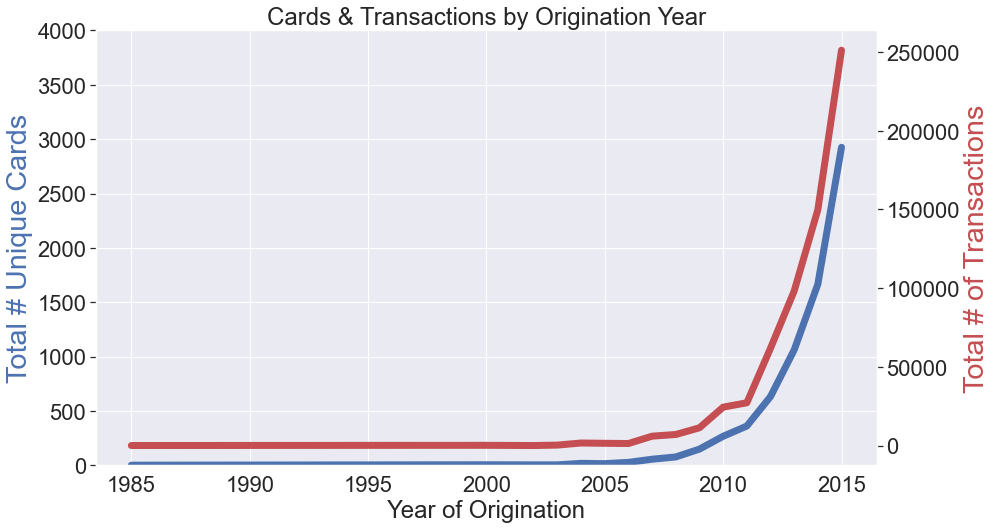

In [15]:
fig, ax1 = plt.subplots()
fig.set_size_inches(14,8, forward = True)
ax2 = ax1.twinx()
ax1.plot(accts_byOrigination['Origination Year']
         , accts_byOrigination['#Cards']
         , 'b-'
         , linewidth=7.0)
ax2.plot(accts_byOrigination['Origination Year']
         , accts_byOrigination['#Transactions']
         , 'r-'
         , linewidth=7.0)
ax1.set_xlabel("Year of Origination")
ax1.set_ylabel("Total # Unique Cards", color = "b", fontsize = "large")
ax2.set_ylabel("Total # of Transactions", color = "r", fontsize = "large")
ax1.set_ylim([0,4000])
plt.title("Cards & Transactions by Origination Year")
plt.grid()
plt.show()

# clean up
del accts_byOrigination

In [16]:
## look at the acc booked in 1985.
df[df['accountOpenDate_year']==1985]
## interesting only used for brick and mortar type of biz

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name
305716,789836144,789836144,5000.0,5000.00,2016-03-02 16:09:59,53.23,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,0.00,1,0,3925789836144,2016-03-02,1900-01-01 16:09:59,1985,12,3,Mar,16,Wednesday
305717,789836144,789836144,5000.0,4946.77,2016-03-13 08:05:38,93.15,West End Beauty #02340,US,US,05,01,personal care,2022-10-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,53.23,1,0,3925789836144,2016-03-13,1900-01-01 08:05:38,1985,12,3,Mar,8,Sunday
305718,789836144,789836144,5000.0,4853.62,2016-03-16 14:57:30,56.04,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,146.38,1,0,3925789836144,2016-03-16,1900-01-01 14:57:30,1985,12,3,Mar,14,Wednesday
305719,789836144,789836144,5000.0,4797.58,2016-03-31 11:54:45,51.42,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,202.42,1,0,3925789836144,2016-03-31,1900-01-01 11:54:45,1985,12,3,Mar,11,Thursday
305720,789836144,789836144,5000.0,4771.16,2016-04-13 19:43:27,45.85,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,228.84,1,0,3925789836144,2016-04-13,1900-01-01 19:43:27,1985,12,4,Apr,19,Wednesday
305721,789836144,789836144,5000.0,4725.31,2016-04-28 07:27:32,45.85,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,274.69,1,0,3925789836144,2016-04-28,1900-01-01 07:27:32,1985,12,4,Apr,7,Thursday
305722,789836144,789836144,5000.0,4704.46,2016-05-04 22:35:16,14.73,53rd Spa,US,US,09,01,personal care,2029-01-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,295.54,1,0,3925789836144,2016-05-04,1900-01-01 22:35:16,1985,12,5,May,22,Wednesday
305723,789836144,789836144,5000.0,4689.73,2016-05-08 04:30:02,145.55,Universe Massage #219515,US,US,05,01,personal care,2018-10-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,310.27,1,0,3925789836144,2016-05-08,1900-01-01 04:30:02,1985,12,5,May,4,Sunday
305724,789836144,789836144,5000.0,4544.18,2016-05-12 08:24:10,59.04,Shell Gas #359650,US,US,02,01,fuel,2031-05-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,455.82,1,0,3925789836144,2016-05-12,1900-01-01 08:24:10,1985,12,5,May,8,Thursday
305725,789836144,789836144,5000.0,4485.14,2016-05-22 03:25:59,479.71,West End Beauty #178111,US,US,02,08,personal care,2022-02-01,1985-12-25,1985-12-25,379,379,3925,PURCHASE,0,514.86,1,0,3925789836144,2016-05-22,1900-01-01 03:25:59,1985,12,5,May,3,Sunday


In [17]:
## helper functions
def categoryPercPlots(var_name, data, tolerance = 1000, fig_size = (14,10)):
    """
    Population percentage by a category variable.
    tolerance : population threshold to display categories.
    """
    data = data.copy()
    data.loc[:,'pop'] = 1
    bar = data.loc[:,[var_name
                      , 'pop']].groupby(var_name).sum('pop').reset_index()
    bar = bar[bar['pop']>=tolerance]
    bar['pop'] = 100*bar['pop']/bar['pop'].sum()
    fig = plt.figure(figsize=fig_size)
    sns.barplot(x=var_name, y='pop', data=bar)
    #plt.rcParams['xtick.labelsize'] = 10 
    plt.xticks(rotation=90)
    plt.show()
    
def categoryPercCounts(var_name, target, data, tolerance = 1000):
    """
    Population percentage by a category variable.
    tolerance : population threshold to display categories.
    """
    data = data.copy()
    data['pop'] = 1
    bar = data.loc[:,[var_name
                      , target
                      , 'pop']].groupby(var_name).agg({'pop':'sum'
                                                       ,target:'mean'}).reset_index()
    bar = bar[bar['pop']>=tolerance]
    bar['popPerc'] = 100*bar['pop']/bar['pop'].sum()
    bar[target] = 100*bar[target]
    return bar.sort_values(target, ascending = False)

def categoryPercCountsByTarget(var_name, target, data):
    """
    Population percentage by a category variable.
    tolerance : population threshold to display categories.
    """
    data = data.copy()
    data['pop'] = 1
    noFraud = data[data[target]==0]
    isFraud = data[data[target]==1]
    bar1 = noFraud.loc[:,[var_name
                          , 'pop']].groupby(var_name).agg({'pop':'sum'
                                                          }).reset_index()
    bar1['pop'] = 100*bar1['pop']/bar1['pop'].sum()
    bar1.columns = [var_name,'Fraud']
    bar2 = isFraud.loc[:,[var_name
                          , 'pop']].groupby(var_name).agg({'pop':'sum'
                                                          }).reset_index()
    bar2['pop'] = 100*bar2['pop']/bar2['pop'].sum()
    bar2.columns = [var_name,'noFraud']
    bar1 = bar1.merge(bar2, on = var_name)
    bar1.plot(x=var_name, y=["Fraud", "noFraud"], kind="bar")

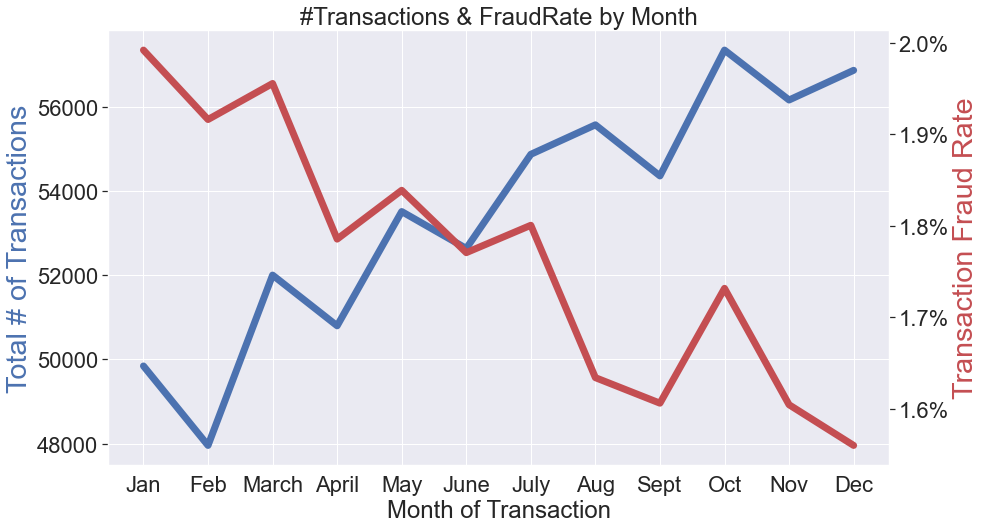

In [18]:
transactions_by_mnt = df[['transactionDate_mnt'
                          ,'CC_ID'
                          ,'isFraud']].groupby('transactionDate_mnt'
                                              ).agg({'CC_ID':['count']
                                                     ,'isFraud':['mean']}).reset_index()
transactions_by_mnt.columns = ['Transaction Month'
                               , '#Transactions'
                               , '#FraudRate']
transactions_by_mnt['#FraudRate'] = transactions_by_mnt['#FraudRate'] *100

transactions_by_mnt['#Transactions'] = transactions_by_mnt['#Transactions']
fig, ax1 = plt.subplots()
fig.set_size_inches(14,8, forward = True)
ax2 = ax1.twinx()
ax1.plot(transactions_by_mnt['Transaction Month']
         , transactions_by_mnt['#Transactions']
         , 'b-'
         , linewidth=7.0)
ax2.plot(transactions_by_mnt['Transaction Month']
         , transactions_by_mnt['#FraudRate']
         , 'r-'
         , linewidth=7.0)
ax1.set_xlabel("Month of Transaction")
ax1.set_ylabel("Total # of Transactions", color = "b", fontsize = "large")
ax2.set_ylabel("Transaction Fraud Rate", color = "r", fontsize = "large")
#ax1.set_ylim([40000,60000])
#ax2.set_ylim([40000,60000])
fmt = '{x:,.1f}%'
tick = mtick.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(transactions_by_mnt['Transaction Month']
           , ['Jan', 'Feb', 'March', 'April'
              , 'May', 'June', 'July', 'Aug'
              , 'Sept', 'Oct','Nov','Dec'])
plt.title("#Transactions & FraudRate by Month")
plt.grid()
plt.show()

# clean up
del transactions_by_mnt

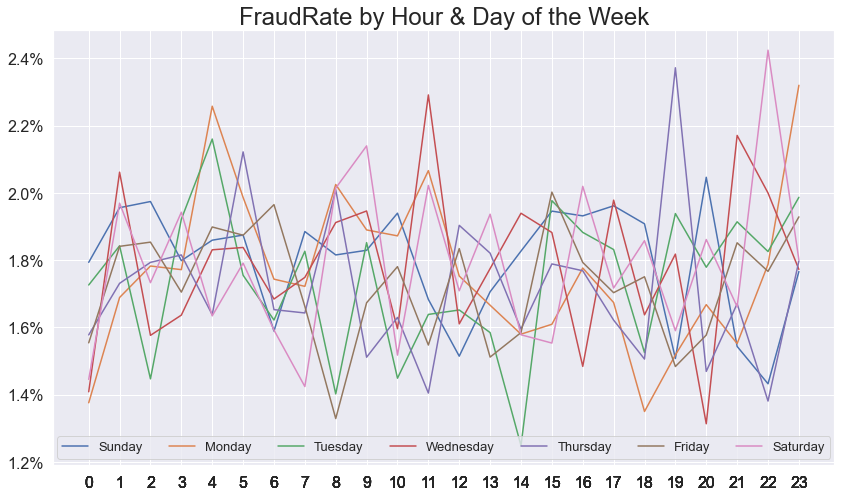

In [19]:
transactions_by_hour = df[['transactionDate_Hour'
                           ,'transactionDate_weekday_name'
                           ,'isFraud']].groupby(['transactionDate_Hour'
                                                , 'transactionDate_weekday_name']
                                               ).agg({'isFraud':['mean']}).reset_index()

transactions_by_hour.columns = ['Transaction Hour'
                               , 'Transaction WeekDay'
                               , '#FraudRate']

transactions_by_hour['#FraudRate'] = transactions_by_hour['#FraudRate'] *100

fig, ax = plt.subplots()
fig.set_size_inches(14,8, forward = True)

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday'
        , 'Thursday', 'Friday', 'Saturday']

COLOR = (0, 0, 0.1)
def color_conv(color_range):
    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 

#cl = 0
for day in days:
    temp = transactions_by_hour[transactions_by_hour['Transaction WeekDay']==day
                               ].sort_values('Transaction Hour'
                                             , ascending = True)
    plt.plot(temp['Transaction Hour']
             , temp['#FraudRate']
             , label=str(day)
#             , color = color_conv(cl/10)
            )
#    cl = cl+1

ax.grid(b=True, which='major', color='w', linestyle='-')
fmt = '{x:,.1f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title("FraudRate by Hour & Day of the Week")
plt.legend(prop={'size':13}, loc='lower center', ncol = 7)
#ax.set_ylim([0.6,1.4])
plt.xticks(transactions_by_hour['Transaction Hour'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [20]:
def day_6_buckets(col):
    """
    Bucket time of the day into 6 buckets
    """
    
    #TODO: Add auto n bucketing
    if col<4:
        return '12AM_to_4AM'
    elif col<8:
        return '4AM_to_8AM'
    elif col<12:
        return '8AM_to_12PM'
    elif col<16:
        return '12PM_to_4PM'
    elif col<20:
        return '4PM_to_8PM'
    else:
        return '8PM_to_12AM'
    
vect_day_6_buckets = np.vectorize(day_6_buckets)
df['time_of_day_buckets'] = vect_day_6_buckets(df['transactionDate_Hour'])
df.head(3)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets
0,733493772,733493772,5000.0,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,01,rideshare,2020-04-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,0.00,0,0,9184733493772,2016-01-08,1900-01-01 19:04:50,2014,8,1,Jan,19,Friday,4PM_to_8PM
1,733493772,733493772,5000.0,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,01,rideshare,2023-06-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,111.33,0,0,9184733493772,2016-01-09,1900-01-01 22:32:39,2014,8,1,Jan,22,Saturday,8PM_to_12AM
2,733493772,733493772,5000.0,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,01,rideshare,2027-12-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,136.08,0,0,9184733493772,2016-01-11,1900-01-01 13:36:55,2014,8,1,Jan,13,Monday,12PM_to_4PM


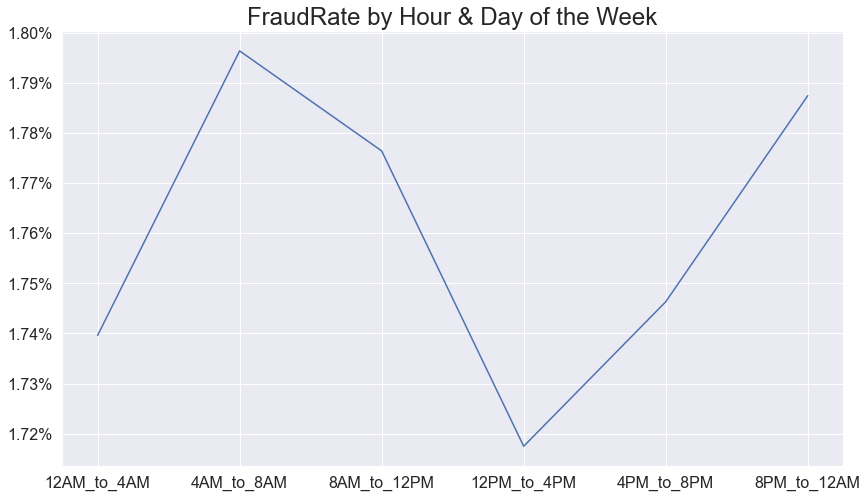

In [21]:
transactions_by_hour = df[['time_of_day_buckets'
                           ,'isFraud']].groupby('time_of_day_buckets' 
                                               ).agg({'isFraud':['mean']}).reset_index()

transactions_by_hour.columns = ['Transaction Hour'
                               , '#FraudRate']

transactions_by_hour['#FraudRate'] = transactions_by_hour['#FraudRate'] *100
order_time = {'12AM_to_4AM':1
              , '4AM_to_8AM':2
              , '8AM_to_12PM':3
              , '12PM_to_4PM':4
              , '4PM_to_8PM':5
              , '8PM_to_12AM':6}
transactions_by_hour['order_time'] = transactions_by_hour['Transaction Hour'].replace(order_time)
transactions_by_hour = transactions_by_hour.sort_values('order_time',ascending = True)

fig, ax = plt.subplots()
fig.set_size_inches(14,8, forward = True)

plt.plot(transactions_by_hour['Transaction Hour']
         , transactions_by_hour['#FraudRate']
        )

ax.grid(b=True, which='major', color='w', linestyle='-')
fmt = '{x:,.2f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title("FraudRate by Hour & Day of the Week")
#ax.set_ylim([1.5,2])
plt.xticks(transactions_by_hour['Transaction Hour'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

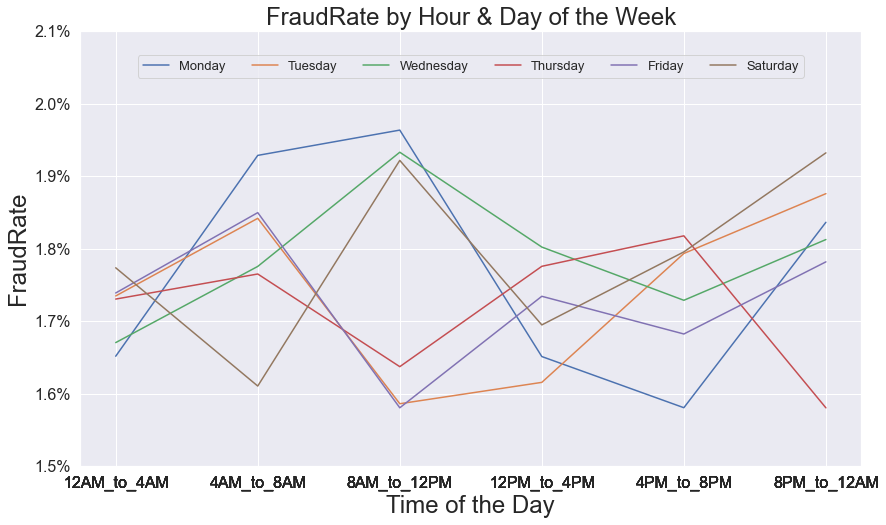

In [22]:
transactions_by_hour = df[['time_of_day_buckets'
                           ,'transactionDate_weekday_name'
                           ,'isFraud']].groupby(['time_of_day_buckets'
                                                , 'transactionDate_weekday_name']
                                               ).agg({'isFraud':['mean']}).reset_index()

transactions_by_hour.columns = ['Transaction Hour'
                               , 'Transaction WeekDay'
                               , '#FraudRate']

transactions_by_hour['#FraudRate'] = transactions_by_hour['#FraudRate'] *100
order_time = {'12AM_to_4AM':1
              , '4AM_to_8AM':2
              , '8AM_to_12PM':3
              , '12PM_to_4PM':4
              , '4PM_to_8PM':5
              , '8PM_to_12AM':6}
transactions_by_hour['order_time'] = transactions_by_hour['Transaction Hour'].replace(order_time)
transactions_by_hour = transactions_by_hour.sort_values('order_time',ascending = True)

fig, ax = plt.subplots()
fig.set_size_inches(14,8, forward = True)

days = ['Monday', 'Tuesday', 'Wednesday'
        , 'Thursday', 'Friday', 'Saturday']

# COLOR = (0, 0, 0.1)
# def color_conv(color_range):
#    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 

#cl = 0
for day in days:
    temp = transactions_by_hour[transactions_by_hour['Transaction WeekDay']==day
                               ].sort_values('order_time'
                                             , ascending = True)
    plt.plot(temp['Transaction Hour']
             , temp['#FraudRate']
             , label=str(day)
#             , color = color_conv(cl/10)
            )
#    cl = cl+1
ax.set_xlabel("Time of the Day")
ax.set_ylabel("FraudRate")
ax.grid(b=True, which='major', color='w', linestyle='-')
fmt = '{x:,.1f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title("FraudRate by Hour & Day of the Week")
plt.legend(prop={'size':13}, loc='upper center', ncol = 7, bbox_to_anchor=(0.5, 0.96))
ax.set_ylim([1.5,2.1])
plt.xticks(transactions_by_hour['Transaction Hour'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

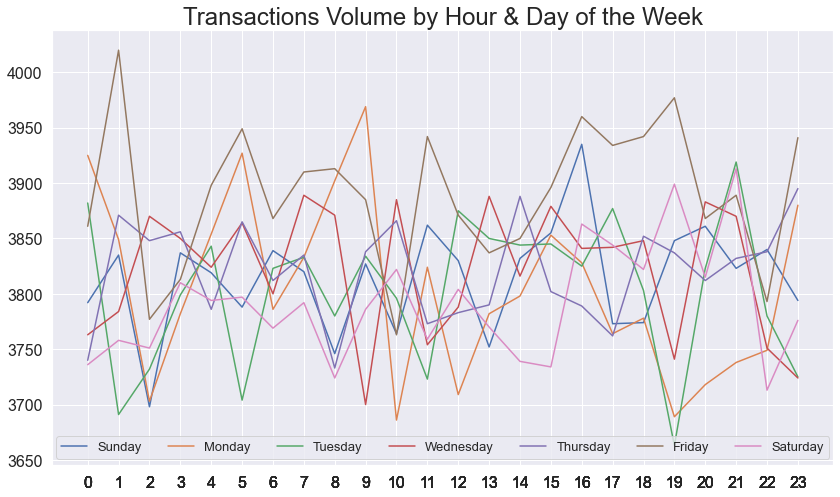

In [23]:
transactions_by_hour = df[['transactionDate_Hour'
                           ,'transactionDate_weekday_name'
                           ,'isFraud']].groupby(['transactionDate_Hour'
                                                , 'transactionDate_weekday_name']
                                               ).agg({'isFraud':['count']}).reset_index()

transactions_by_hour.columns = ['Transaction Hour'
                               , 'Transaction WeekDay'
                               , '#Transactions']


fig, ax = plt.subplots()
fig.set_size_inches(14,8, forward = True)

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday'
        , 'Thursday', 'Friday', 'Saturday']

COLOR = (0, 0, 0.1)
def color_conv(color_range):
    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 

#cl = 0
for day in days:
    temp = transactions_by_hour[transactions_by_hour['Transaction WeekDay']==day
                               ].sort_values('Transaction Hour'
                                             , ascending = True)
    plt.plot(temp['Transaction Hour']
             , temp['#Transactions']
             , label=str(day)
#             , color = color_conv(cl/10)
            )
#    cl = cl+1

ax.grid(b=True, which='major', color='w', linestyle='-')
plt.title("Transactions Volume by Hour & Day of the Week")
plt.legend(prop={'size':13}, loc='lower center', ncol = 7)
#ax.set_ylim([0.6,1.4])
plt.xticks(transactions_by_hour['Transaction Hour'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

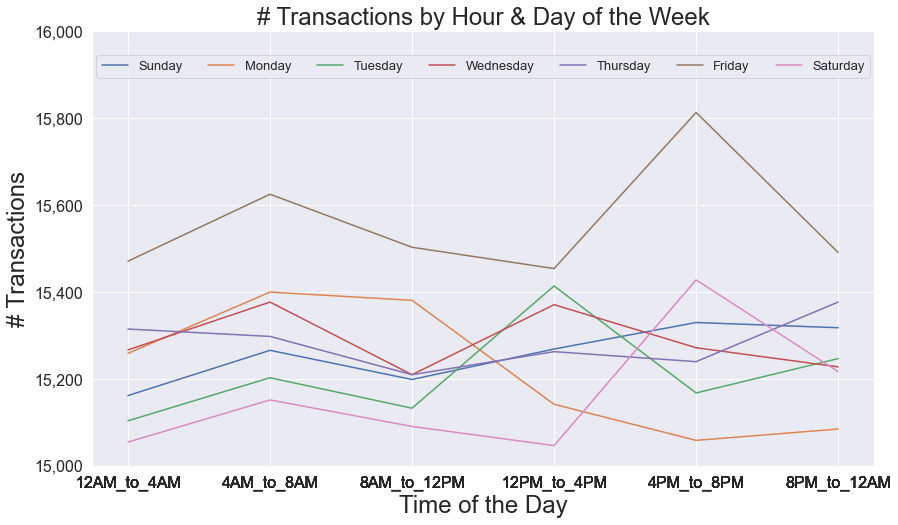

In [24]:
transactions_by_hour = df[['time_of_day_buckets'
                           ,'transactionDate_weekday_name'
                           ,'isFraud']].groupby(['time_of_day_buckets'
                                                , 'transactionDate_weekday_name']
                                               ).agg({'isFraud':['count']}).reset_index()

transactions_by_hour.columns = ['Transaction Hour'
                               , 'Transaction WeekDay'
                               , '#FraudRate']

transactions_by_hour['#FraudRate'] = transactions_by_hour['#FraudRate']
order_time = {'12AM_to_4AM':1
              , '4AM_to_8AM':2
              , '8AM_to_12PM':3
              , '12PM_to_4PM':4
              , '4PM_to_8PM':5
              , '8PM_to_12AM':6}
transactions_by_hour['order_time'] = transactions_by_hour['Transaction Hour'].replace(order_time)
transactions_by_hour = transactions_by_hour.sort_values('order_time',ascending = True)

fig, ax = plt.subplots()
fig.set_size_inches(14,8, forward = True)

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday'
        , 'Thursday', 'Friday', 'Saturday']

# COLOR = (0, 0, 0.1)
# def color_conv(color_range):
#    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 

#cl = 0
for day in days:
    temp = transactions_by_hour[transactions_by_hour['Transaction WeekDay']==day
                               ].sort_values('order_time'
                                             , ascending = True)
    plt.plot(temp['Transaction Hour']
             , temp['#FraudRate']
             , label=str(day)
#             , color = color_conv(cl/10)
            )
#    cl = cl+1

ax.grid(b=True, which='major', color='w', linestyle='-')
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title("# Transactions by Hour & Day of the Week")
ax.set_xlabel("Time of the Day")
ax.set_ylabel("# Transactions")
plt.legend(prop={'size':13}, loc='upper center', ncol = 7, bbox_to_anchor=(0.5, 0.96))
ax.set_ylim([15000,16000])
plt.xticks(transactions_by_hour['Transaction Hour'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

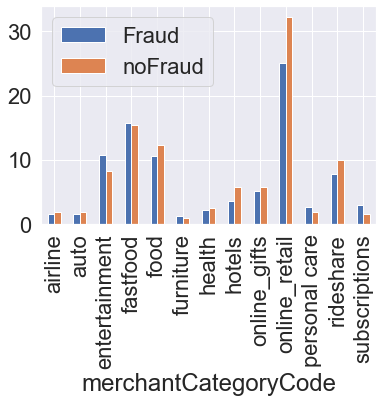

In [25]:
categoryPercCountsByTarget('merchantCategoryCode', 'isFraud', df)

# of unique values - 19


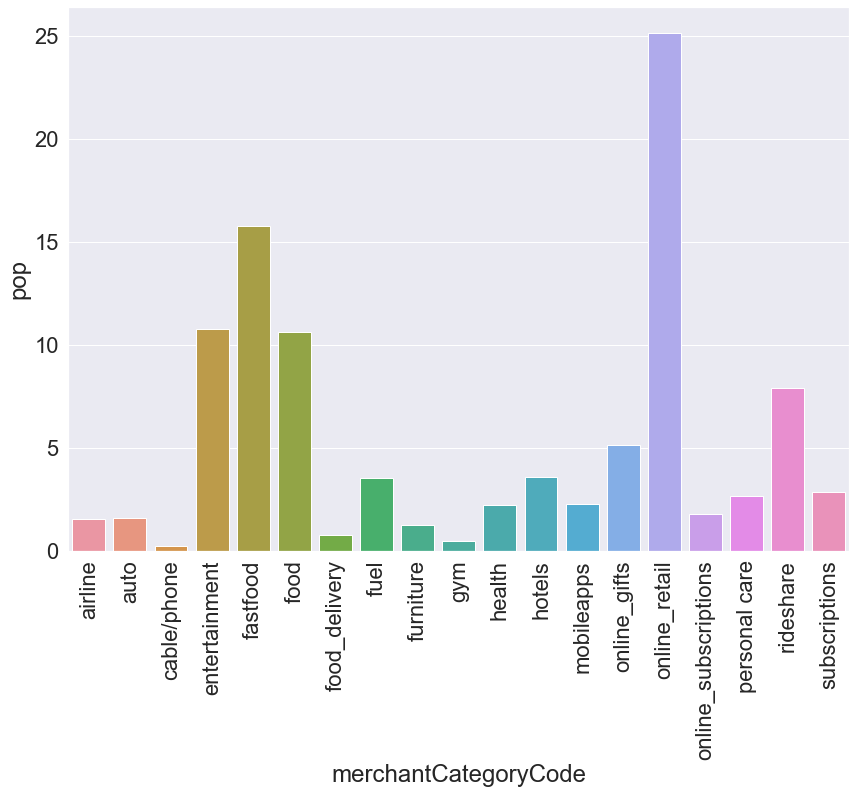

In [26]:
# hist transactions by merchant type
print(f"# of unique values - {df['merchantCategoryCode'].nunique()}")
categoryPercPlots('merchantCategoryCode', df, tolerance = 0)

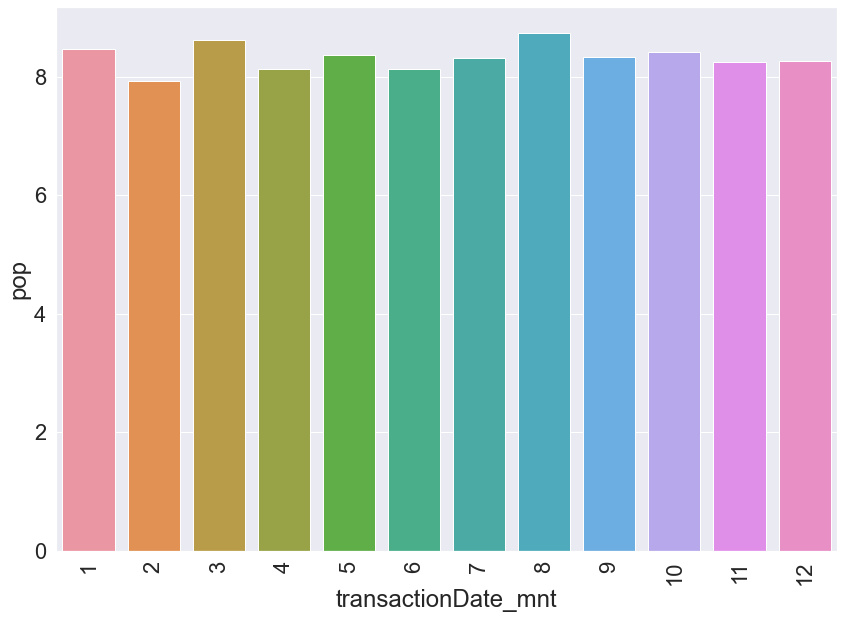

In [27]:
categoryPercPlots('transactionDate_mnt', df[df.loc[:,'merchantCategoryCode']=='rideshare'])

In [28]:
categoryPercCounts('merchantCategoryCode', 'isFraud', df, tolerance = 1000)

,merchantCategoryCode,pop,isFraud,popPerc
11,hotels,22879,2.841033,3.564185
14,online_retail,161469,2.258638,25.154304
17,rideshare,50574,2.224463,7.878625
1,auto,10147,2.079432,1.580741
0,airline,9990,2.062062,1.556283
5,food,68245,2.036779,10.631486
13,online_gifts,33045,1.979119,5.147886
10,health,14344,1.917178,2.234567
4,fastfood,101196,1.716471,15.764729
3,entertainment,69138,1.342243,10.770602


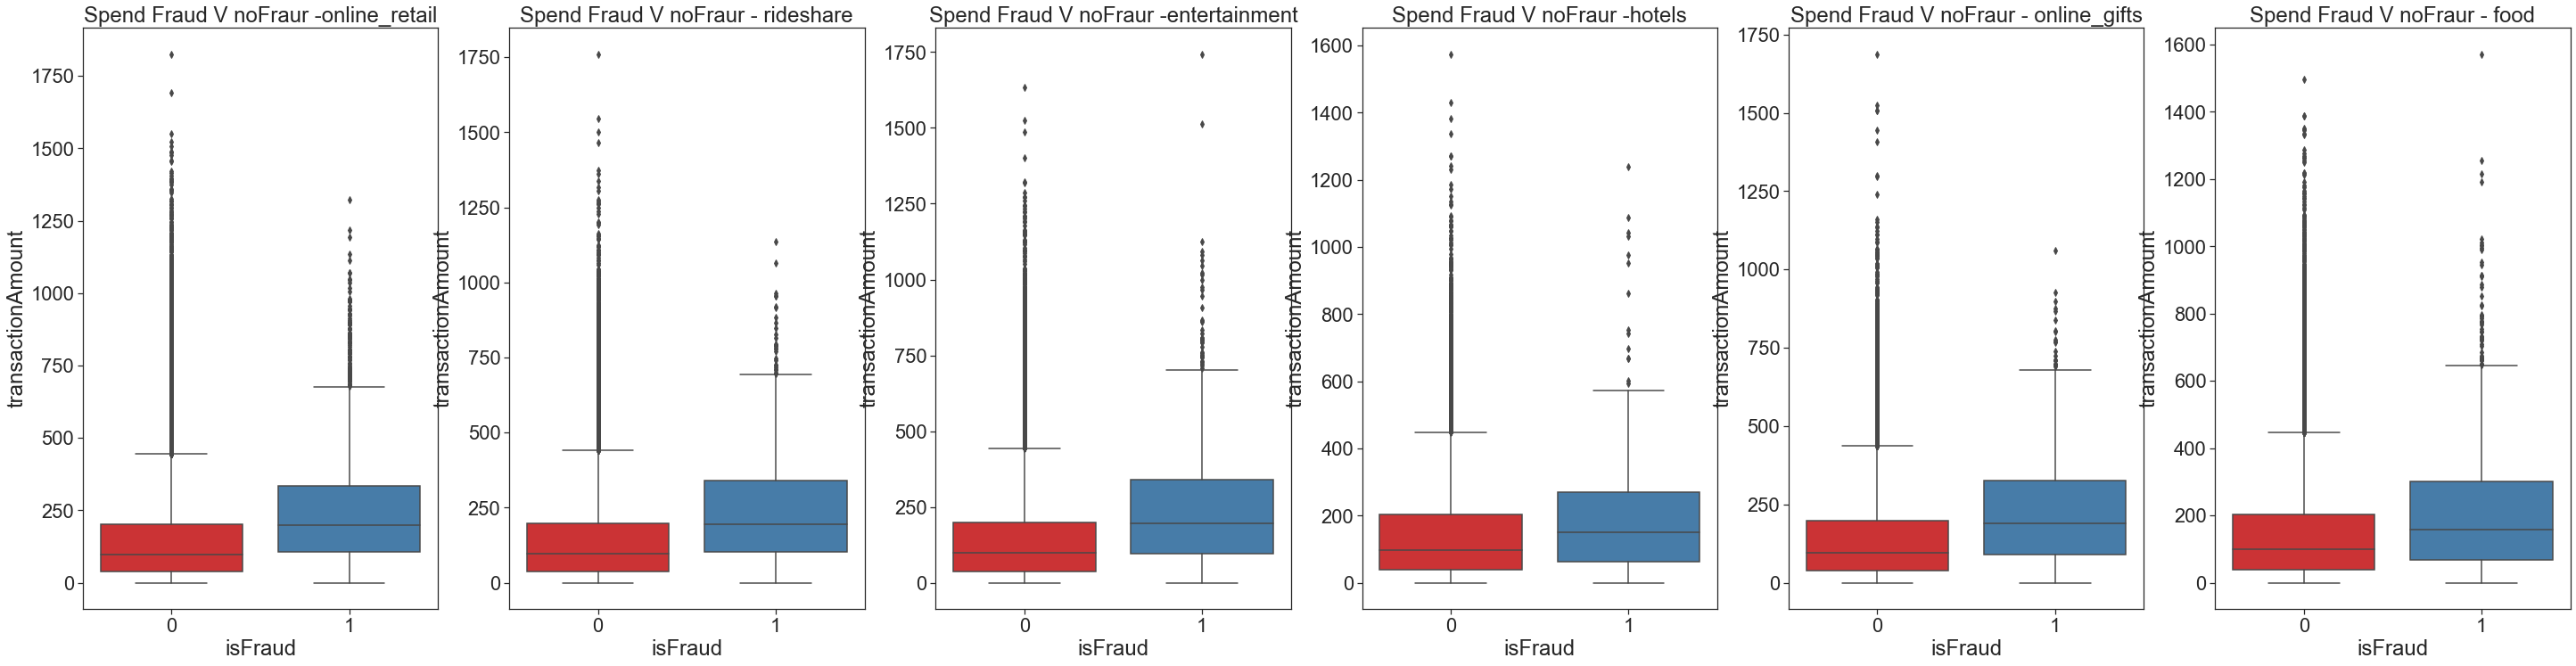

In [29]:
## average money spent at a merchant fraud/nofraud
sns.set_style('ticks')
f, axes = plt.subplots(ncols=6, figsize=(50,12))

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='online_retail'], palette='Set1', ax=axes[0])
axes[0].set_title('Spend Fraud V noFraur -online_retail')

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='rideshare'], palette='Set1', ax=axes[1])
axes[1].set_title('Spend Fraud V noFraur - rideshare')

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='entertainment'], palette='Set1', ax=axes[2])
axes[2].set_title('Spend Fraud V noFraur -entertainment')

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='hotels'], palette='Set1', ax=axes[3])
axes[3].set_title('Spend Fraud V noFraur -hotels')

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='online_gifts'], palette='Set1', ax=axes[4])
axes[4].set_title('Spend Fraud V noFraur - online_gifts')

sns.boxplot(x='isFraud', y='transactionAmount'
            , data=df[df['merchantCategoryCode']=='food'], palette='Set1', ax=axes[5])
axes[5].set_title('Spend Fraud V noFraur - food')


plt.show()

In [30]:
categoryPercCounts('creditLimit', 'isFraud', df, tolerance = 1000)

,creditLimit,pop,isFraud,popPerc
5,7500.0,105340,2.009683,16.410298
8,20000.0,64307,1.900260,10.018009
9,50000.0,38039,1.763979,5.925872
6,10000.0,67477,1.762082,10.511844
7,15000.0,91936,1.751218,14.322168
4,5000.0,127001,1.749593,19.784738
2,1000.0,27861,1.582858,4.340301
3,2500.0,59421,1.580249,9.256847
0,250.0,27781,1.493827,4.327838
1,500.0,32751,1.453391,5.102085


In [31]:
cl_buckets = [0,5000,15000,50000]
df['creditLimit_buckets'] =pd.cut(df['creditLimit']
                                  , cl_buckets)
df['creditLimit_buckets'].unique()

[(0, 5000], (5000, 15000], (15000, 50000]]
Categories (3, interval[int64]): [(0, 5000] < (5000, 15000] < (15000, 50000]]

In [32]:
spend_trends = df[['creditLimit_buckets'
                   ,'merchantCategoryCode'
                   , 'transactionDateTime'
                   ,'isFraud']
                 ].groupby(['creditLimit_buckets'
                            , 'merchantCategoryCode']
                          ).agg({'isFraud':'mean'
                                 , 'transactionDateTime':'count'}
                               ).reset_index()
spend_trends.columns = ['creditLimit_buckets'
                        , 'merchantCategoryCode'
                        , 'FraudRate'
                        , 'pop']

pop_by_clbucket = df[['creditLimit_buckets'
                      , 'transactionDateTime']
                    ].groupby('creditLimit_buckets'
                             ).agg({'transactionDateTime':'count'}
                                  ).reset_index()
pop_by_clbucket.columns = ['creditLimit_buckets','tot_pop']

spend_trends = spend_trends.merge(pop_by_clbucket, on = 'creditLimit_buckets')
spend_trends['pop_prop'] = 100*spend_trends['pop']/spend_trends['tot_pop']

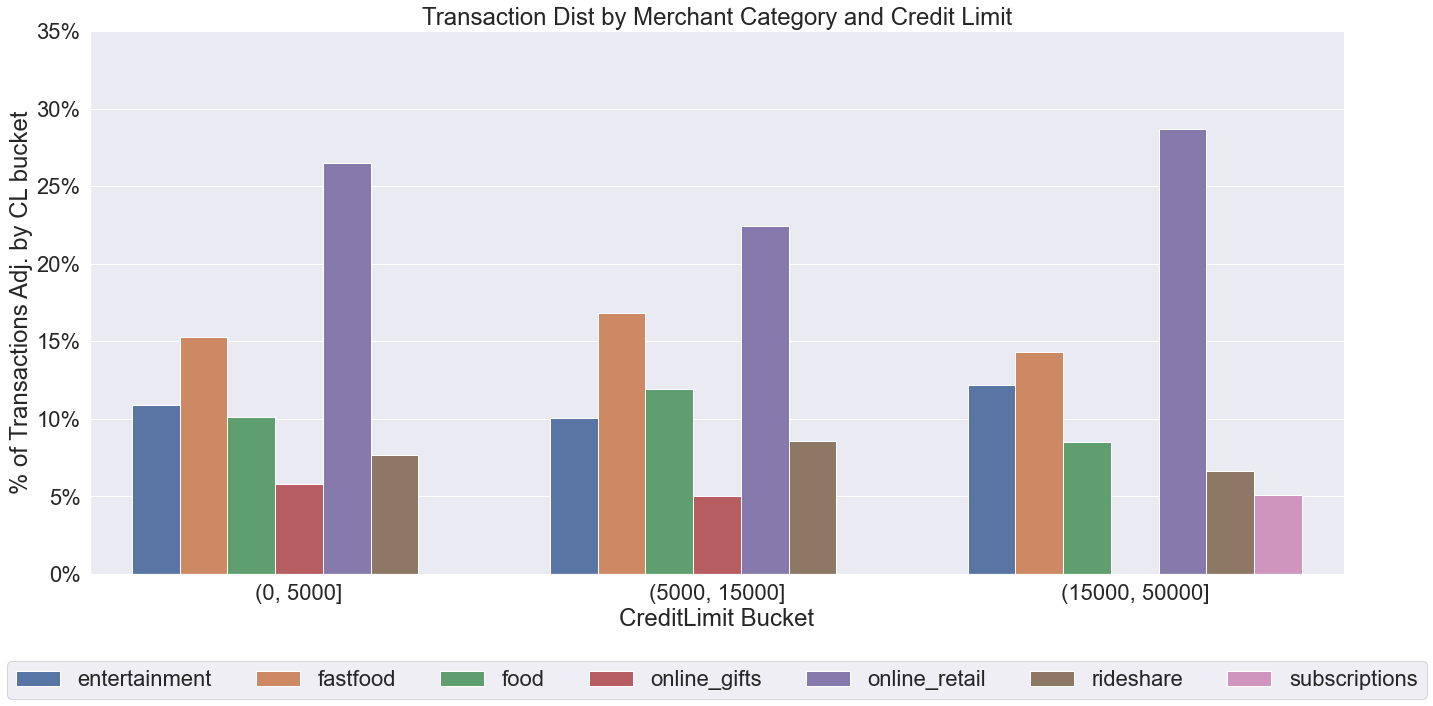

In [33]:
temp = spend_trends[spend_trends['pop_prop']>=5]
temp = temp.loc[:,['creditLimit_buckets'
                   , 'merchantCategoryCode'
                   , 'pop_prop']
               ]
temp['creditLimit_buckets'] = temp['creditLimit_buckets'].astype(str)

sns.set(font_scale = 2)
#sns.set(style="grey")
g = sns.catplot(x = 'creditLimit_buckets'
                , y = 'pop_prop'
                , hue = 'merchantCategoryCode'
                , data = temp
                , kind = 'bar'
                , order = ["(0, 5000]"
                           , "(5000, 15000]"
                           , "(15000, 50000]"]
                , legend = False
               )
g.set_xticklabels(rotation = 0)
g.fig.set_size_inches(26,10)
g.set_axis_labels('CreditLimit Bucket', '% of Transactions Adj. by CL bucket')
g.set_yticklabels(["0%", "5%","10%","15%","20%","25%","30%", "35%"])
axes = g.axes.flatten()
axes[0].set_title("Transaction Dist by Merchant Category and Credit Limit")
plt.legend(loc='lower center', ncol = 7, bbox_to_anchor=(0.5, -0.25))
del temp

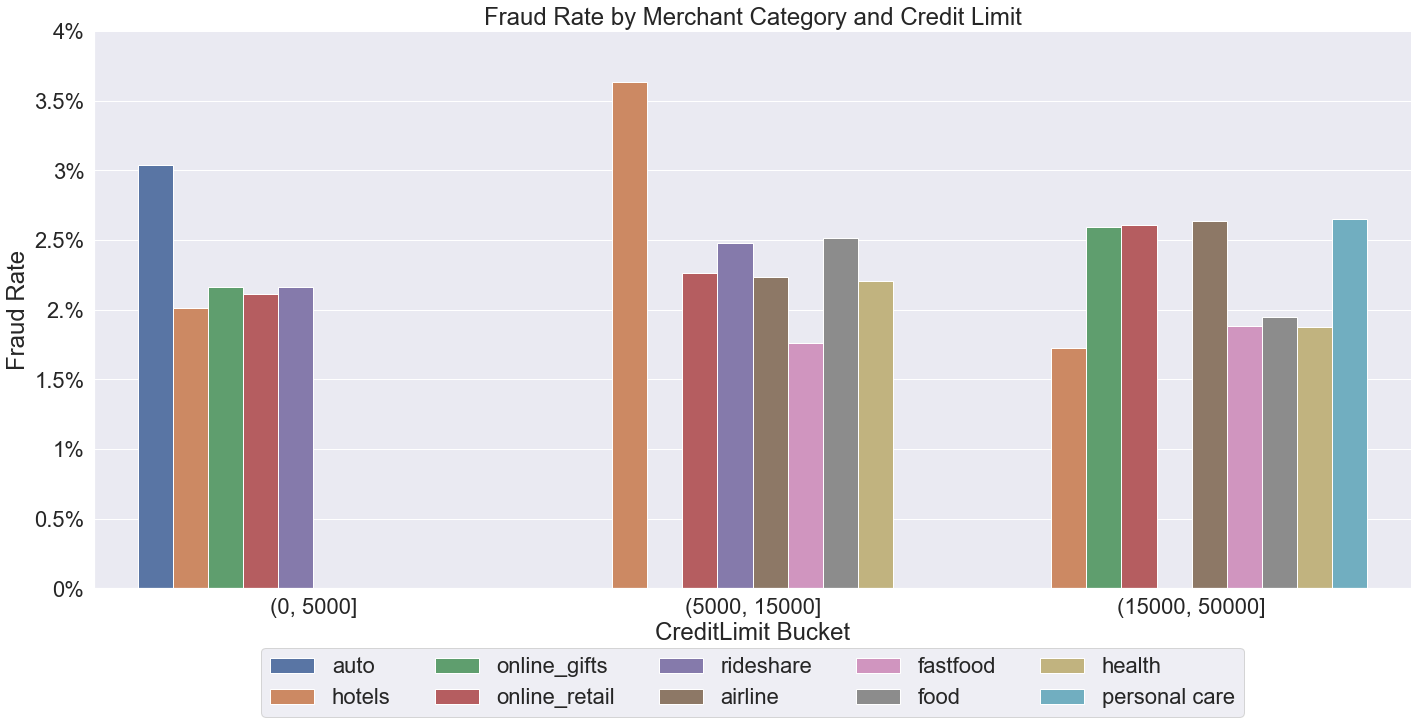

In [34]:
# Fraud Rate by merchant code and credit limit
temp = spend_trends[spend_trends['FraudRate']>0.017]
temp = temp.loc[:,['creditLimit_buckets'
                   , 'merchantCategoryCode'
                   , 'FraudRate']
               ]
temp['FraudRate'] = 100*temp['FraudRate']
temp['creditLimit_buckets'] = temp['creditLimit_buckets'].astype(str)

sns.set(font_scale = 2)
#sns.set(style="grey")
g = sns.catplot(x = 'creditLimit_buckets'
                , y = 'FraudRate'
                , hue = 'merchantCategoryCode'
                , data = temp
                , kind = 'bar'
                , order = ["(0, 5000]"
                           , "(5000, 15000]"
                           , "(15000, 50000]"]
                , legend = False
               )
g.set_xticklabels(rotation = 0)
g.fig.set_size_inches(26,10)
g.set_axis_labels('CreditLimit Bucket', 'Fraud Rate')
g.set_yticklabels(["0%", "0.5%","1%","1.5%","2.%","2.5%","3%", "3.5%","4%"])
axes = g.axes.flatten()
axes[0].set_title("Fraud Rate by Merchant Category and Credit Limit")
plt.legend(loc='lower center', ncol = 5, bbox_to_anchor=(0.5, -0.25))
del temp

In [35]:
df['merchantName'].nunique()

2493

In [36]:
pd.DataFrame({'name':df['merchantName'].unique()})
## looks like same merchant but different location?
## so remove the #number to get just the name

,name
0,Lyft
1,Uber
2,Fresh eCards
3,Universe Massage #95463
4,Universe Massage #70014
5,Universe Massage #596422
6,Hardee's #354068
7,86th Massage
8,West End Beauty #721713
9,Quizno's #353204


# of unique values - 205


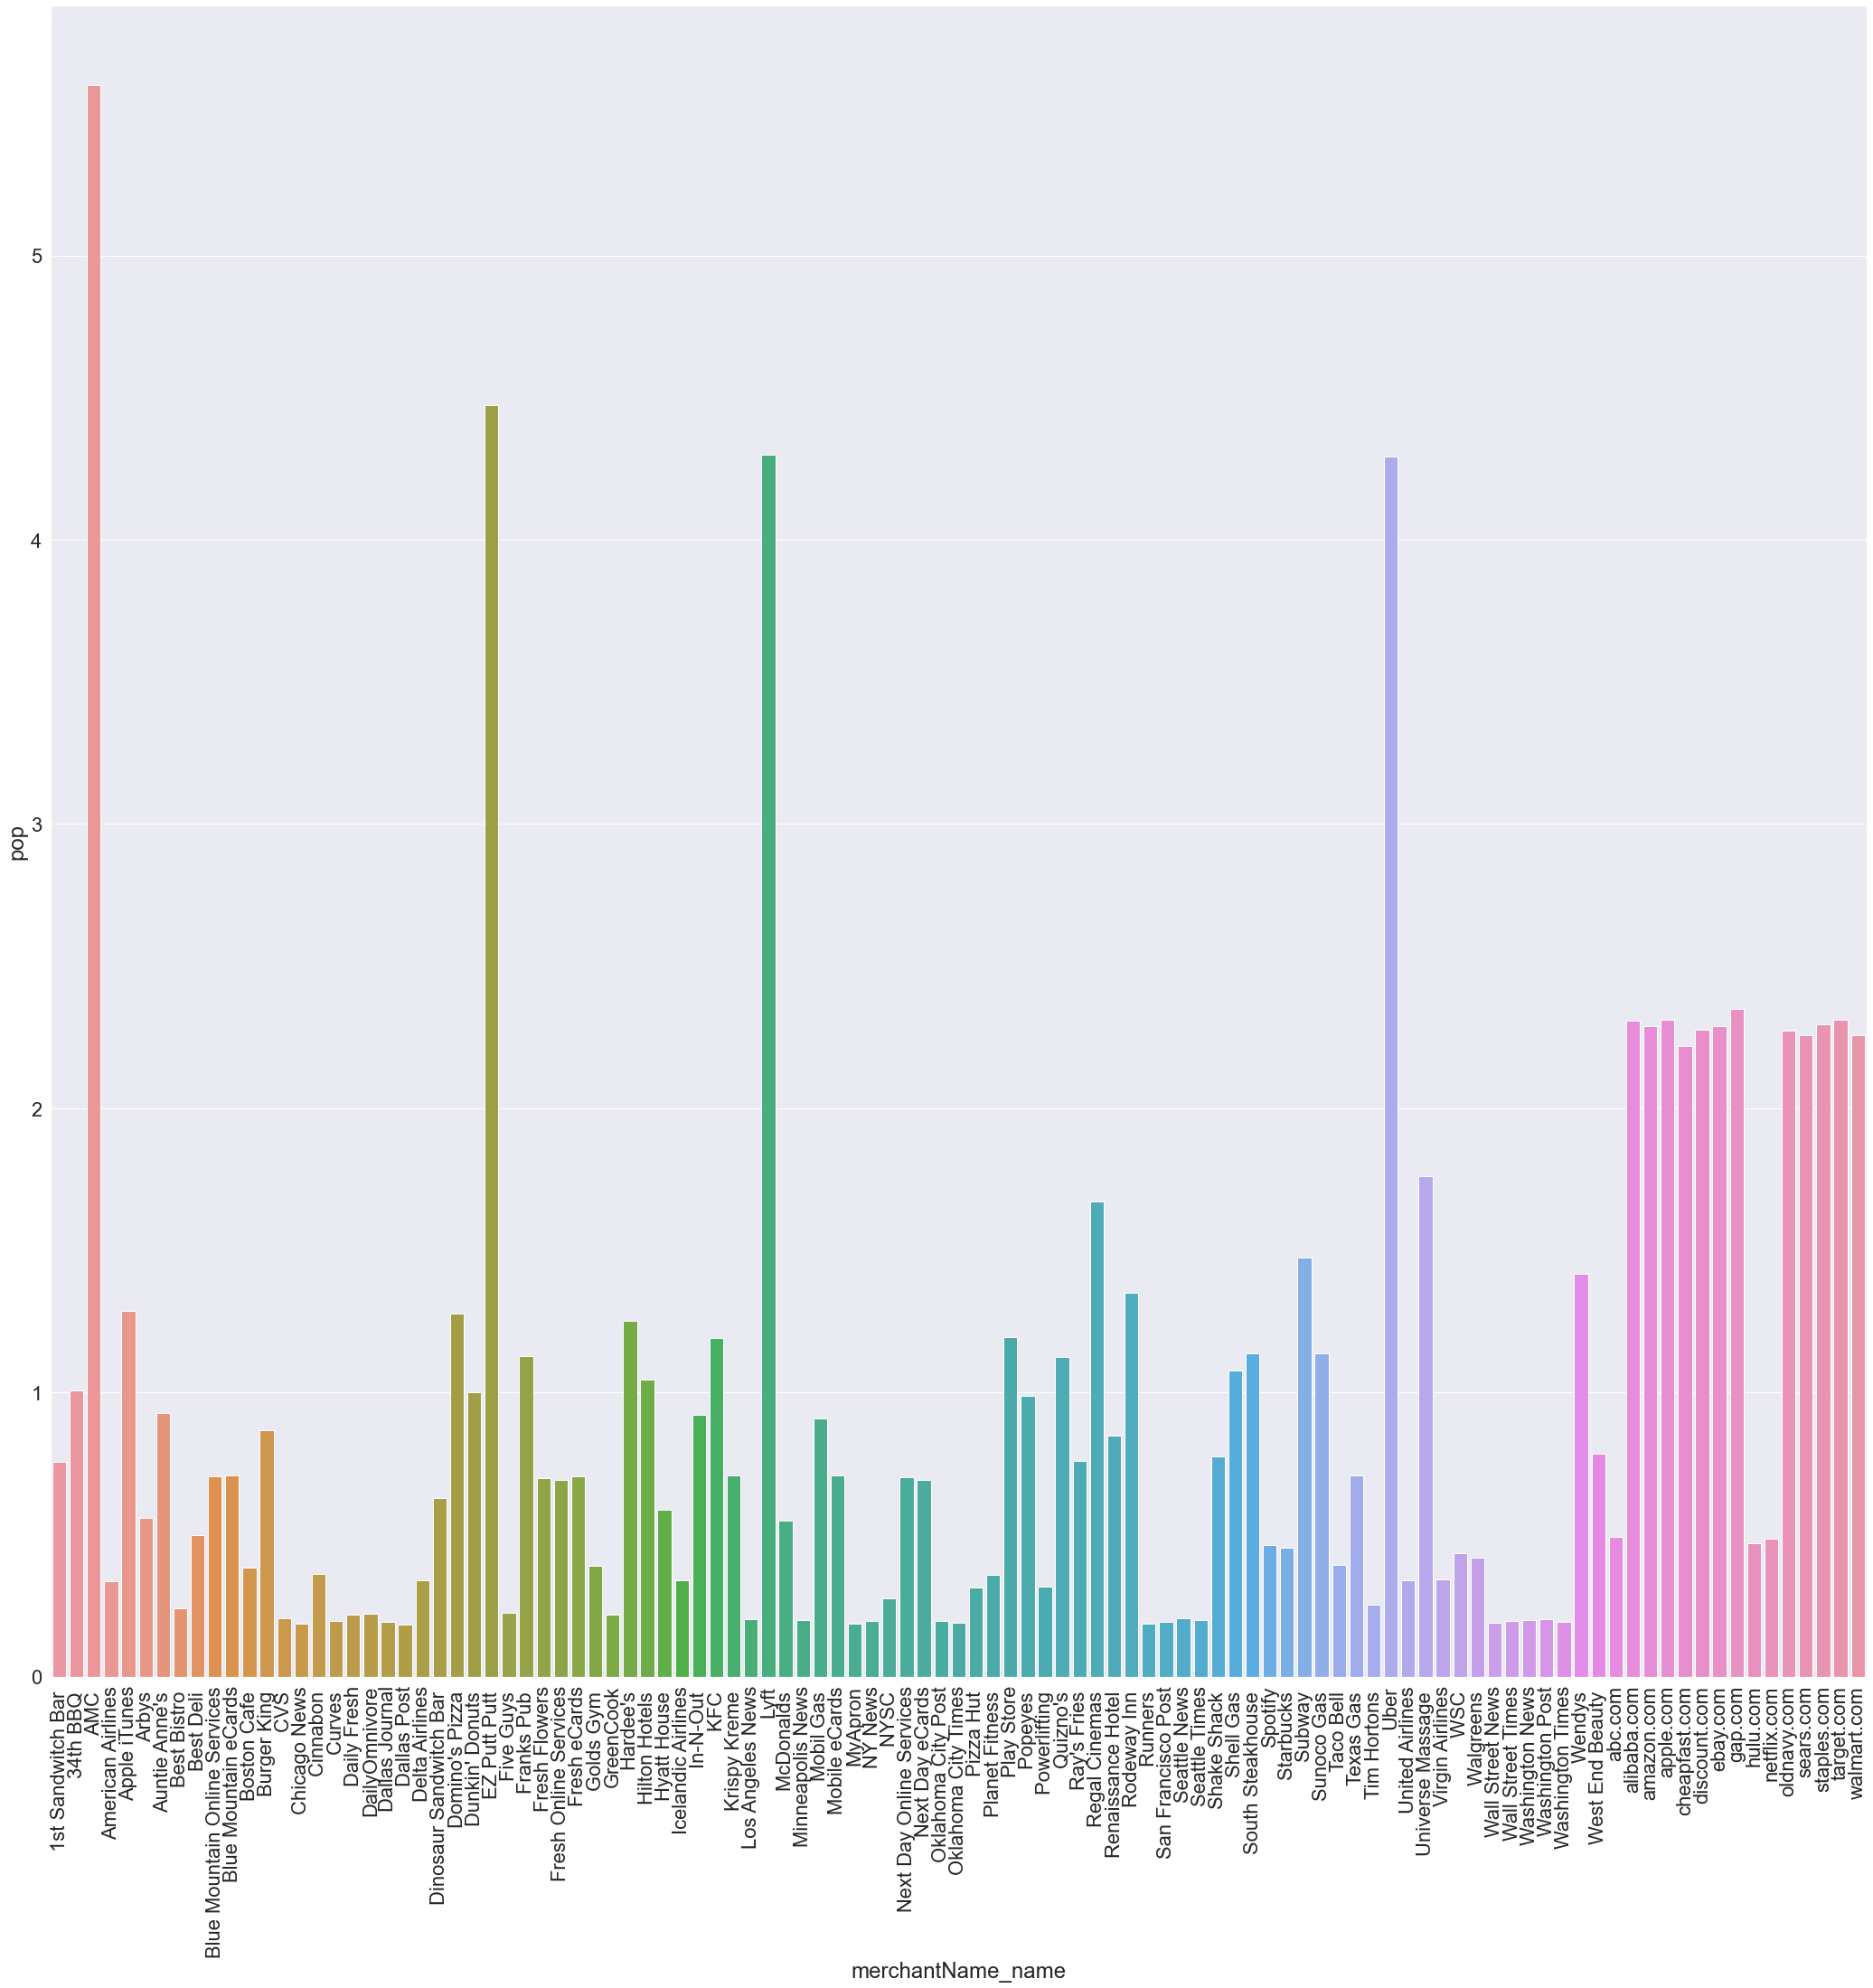

In [37]:
df[['merchantName_name', 'merchantName_id']] = df['merchantName'].str.split('#', expand = True)
# hist transactions by merchant 
print(f"# of unique values - {df['merchantName_name'].nunique()}")
categoryPercPlots('merchantName_name', df, tolerance = 1000, fig_size = (36,34))

In [38]:
categoryPercCounts('merchantName_name', 'isFraud', df, tolerance = 2000)

,merchantName_name,pop,isFraud,popPerc
85,Hyatt House,3451,10.199942,0.633990
5,34th BBQ,5927,4.066138,1.088862
32,Boston Cafe,2257,3.012849,0.414638
87,In-N-Out,5421,3.006825,0.995903
185,alibaba.com,13583,2.981668,2.495361
53,Dinosaur Sandwitch Bar,3699,2.757502,0.679551
201,target.com,13601,2.632159,2.498668
199,sears.com,13279,2.620679,2.439513
181,West End Beauty,4615,2.470206,0.847831
187,apple.com,13607,2.417873,2.499770


# of unique values - 5


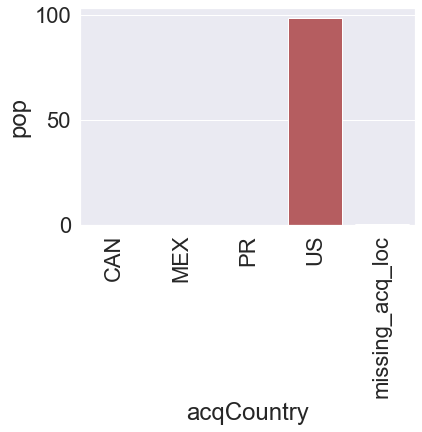

In [39]:
# hist transactions by merchant type
df['acqCountry'] = df['acqCountry'].astype(str).replace('','missing_acq_loc')
print(f"# of unique values - {df['acqCountry'].nunique()}")
categoryPercPlots('acqCountry', df, tolerance = 1000, fig_size = (6,4))

In [40]:
categoryPercCounts('acqCountry', 'isFraud', df, tolerance = 0)

,acqCountry,pop,isFraud,popPerc
4,missing_acq_loc,3913,3.475594,0.609583
0,CAN,1870,2.673797,0.291316
2,PR,1202,2.662230,0.187252
1,MEX,2626,2.208682,0.409089
3,US,632303,1.743784,98.502759


# of unique values - 4


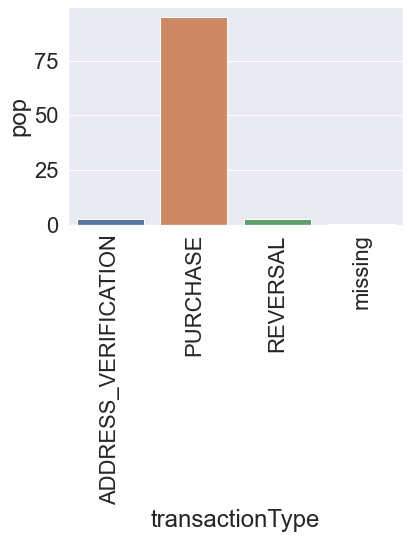

In [41]:
# hist transactions by merchant type
df['transactionType'] = df['transactionType'].astype(str).replace('','missing')
print(f"# of unique values - {df['transactionType'].nunique()}")
categoryPercPlots('transactionType', df, tolerance = 0, fig_size = (6,4))

In [42]:
categoryPercCounts('transactionType', 'isFraud', df, tolerance = 0)

,transactionType,pop,isFraud,popPerc
3,missing,589,2.037351,0.091757
2,REVERSAL,16162,1.812894,2.517783
1,PURCHASE,608685,1.792389,94.823450
0,ADDRESS_VERIFICATION,16478,0.527977,2.567011


# of unique values - 5


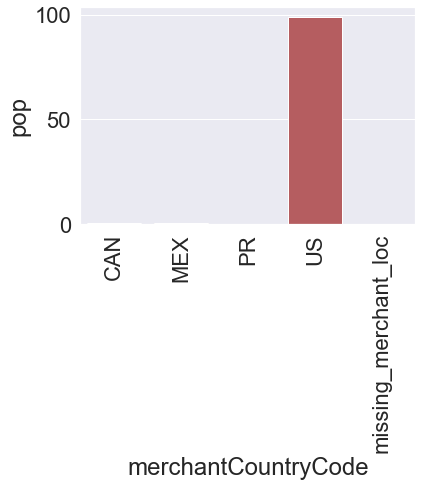

In [43]:
# hist transactions by merchant type
df['merchantCountryCode'] = df['merchantCountryCode'].astype(str).replace('','missing_merchant_loc')
print(f"# of unique values - {df['merchantCountryCode'].nunique()}")
categoryPercPlots('merchantCountryCode', df, tolerance = 0, fig_size = (6,4))

In [44]:
categoryPercCounts('merchantCountryCode', 'isFraud', df, tolerance = 0)

,merchantCountryCode,pop,isFraud,popPerc
4,missing_merchant_loc,624,12.980769,0.097209
0,CAN,1874,2.828175,0.291939
2,PR,1203,2.660017,0.187408
1,MEX,2636,2.238240,0.410647
3,US,635577,1.742826,99.012796


# of unique values - 6


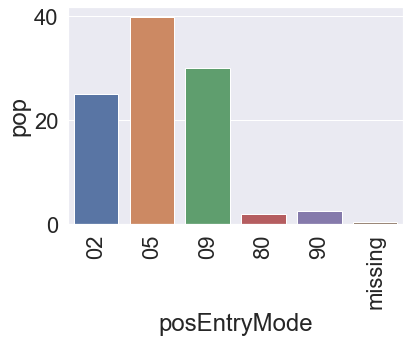

In [45]:
# hist transactions by merchant type
df['posEntryMode'] = df['posEntryMode'].astype(str).replace('','missing')
print(f"# of unique values - {df['posEntryMode'].nunique()}")
categoryPercPlots('posEntryMode', df, tolerance = 0, fig_size = (6,4))

In [46]:
categoryPercCounts('posEntryMode', 'isFraud', df, tolerance = 0)

,posEntryMode,pop,isFraud,popPerc
5,missing,3345,7.713004,0.521098
2,09,193193,2.788403,30.096399
4,90,16251,2.018337,2.531648
0,02,160589,1.905485,25.017214
3,80,12921,1.462735,2.012886
1,05,255615,0.813724,39.820755


# of unique values - 4


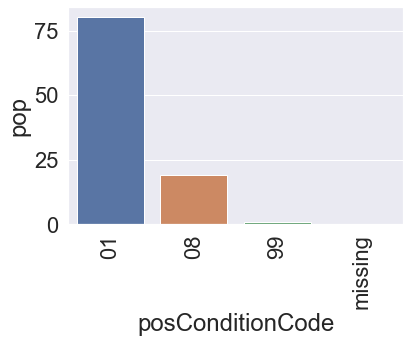

In [47]:
# hist transactions by merchant type
df['posConditionCode'] = df['posConditionCode'].astype(str).replace('','missing')
print(f"# of unique values - {df['posConditionCode'].nunique()}")
categoryPercPlots('posConditionCode', df, tolerance = 0, fig_size = (6,4))

In [48]:
categoryPercCounts('posConditionCode', 'isFraud', df, tolerance = 0)

,posConditionCode,pop,isFraud,popPerc
3,missing,287,4.529617,0.044710
2,99,5976,3.681392,0.930966
0,01,514144,1.824975,80.095465
1,08,121507,1.387574,18.928860


In [49]:
# fraud by card present
categoryPercCounts('cardPresent', 'isFraud', df, tolerance = 0)

,cardPresent,pop,isFraud,popPerc
0,0,340453,1.945643,53.037167
1,1,301461,1.551776,46.962833


In [50]:
categoryPercCounts('expirationDateKeyInMatch', 'isFraud', df, tolerance = 0)

,expirationDateKeyInMatch,pop,isFraud,popPerc
0,0,640945,1.761306,99.849045
1,1,969,1.341589,0.150955


In [51]:
# fraud by card cvv and entered cvv
df['cardCVVMatch'] = (df['cardCVV']==df['enteredCVV']).astype(int)
categoryPercCounts('cardCVVMatch', 'isFraud', df, tolerance = 0)

,cardCVVMatch,pop,isFraud,popPerc
0,0,5937,3.284487,0.92489
1,1,635977,1.746447,99.07511


In [52]:
# Domestic Purchase
df['DomesticPurchase'] = (df['acqCountry']==df['merchantCountryCode']).astype(int)
categoryPercCounts('DomesticPurchase', 'isFraud', df, tolerance = 0)

,DomesticPurchase,pop,isFraud,popPerc
0,0,3975,3.522013,0.619242
1,1,637939,1.749697,99.380758


In [53]:
categoryPercCounts('creditLimit', 'isFraud', df, tolerance = 0)

,creditLimit,pop,isFraud,popPerc
5,7500.0,105340,2.009683,16.410298
8,20000.0,64307,1.900260,10.018009
9,50000.0,38039,1.763979,5.925872
6,10000.0,67477,1.762082,10.511844
7,15000.0,91936,1.751218,14.322168
4,5000.0,127001,1.749593,19.784738
2,1000.0,27861,1.582858,4.340301
3,2500.0,59421,1.580249,9.256847
0,250.0,27781,1.493827,4.327838
1,500.0,32751,1.453391,5.102085


In [54]:
def true_ntile(df, var, ntile = 10):
    ntile_list = [df[var].min()]
    nvar = int(100/ntile)
    for i in range(1,ntile+1):
        a = (np.percentile(df[var], nvar*i))
        ntile_list.insert(len(ntile_list),a)
    ntile_list[-1] = df[var].max()
    return ntile_list

def ntile_dist(df, var, target, ntile = 10):
    df = df.copy()
    df['pop'] = 1
    ntile_ls = true_ntile(df, var, ntile)
    df['N-tile buckets'] = pd.cut(df[var], ntile_ls)
    bin_dist = df.loc[:,['N-tile buckets'
                         ,target
                         ,'pop']].groupby('N-tile buckets').agg({target:'mean'
                                                                 ,'pop':'sum'}).reset_index()
    bin_dist['isFraud'] = bin_dist['isFraud']*100
    bin_dist['pop'] = 100*bin_dist['pop']/bin_dist['pop'].sum()
    return bin_dist.sort_values('isFraud', ascending = False)

In [55]:
# fraud by transaction spend
ntile_dist(df,'transactionAmount','isFraud', ntile=10)

,N-tile buckets,isFraud,pop
9,"(326.58, 1825.25]",4.354261,10.296182
8,"(222.48, 326.58]",3.022278,10.296182
7,"(161.8, 222.48]",2.420862,10.296502
6,"(118.82, 161.8]",2.060972,10.296663
5,"(85.8, 118.82]",1.659447,10.294257
4,"(60.53, 85.8]",1.344614,10.294898
3,"(41.13, 60.53]",0.953301,10.297465
2,"(23.82, 41.13]",0.772778,10.295219
1,"(8.6, 23.82]",0.619851,10.299229
0,"(0.0, 8.6]",0.358713,7.333403


Text(0.5, 1.0, 'Transaction Amount density dist by Fraud')

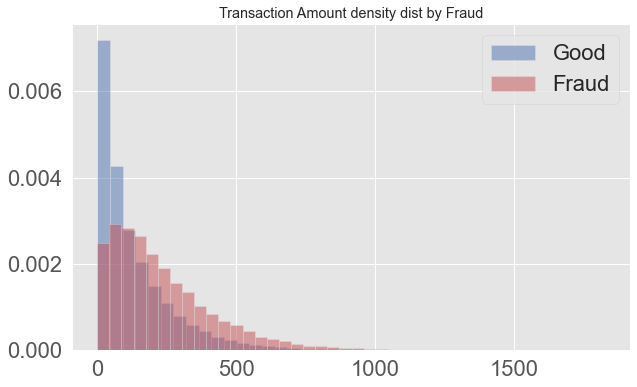

In [56]:
# distribution of transaction by fraud
fig = plt.figure(figsize = (10,6))
matplotlib.style.use('ggplot')
plt.hist(df[df['isFraud']==0]['transactionAmount'], density = True, alpha = 0.5, label = 'Good', bins = 40, color = 'b')
plt.hist(df[df['isFraud']==1]['transactionAmount'], density = True, alpha = 0.5, label = 'Fraud', bins = 40, color = 'r')
plt.legend(loc = 'upper right')
plt.title('Transaction Amount density dist by Fraud')

FixedFormatter should only be used together with FixedLocator


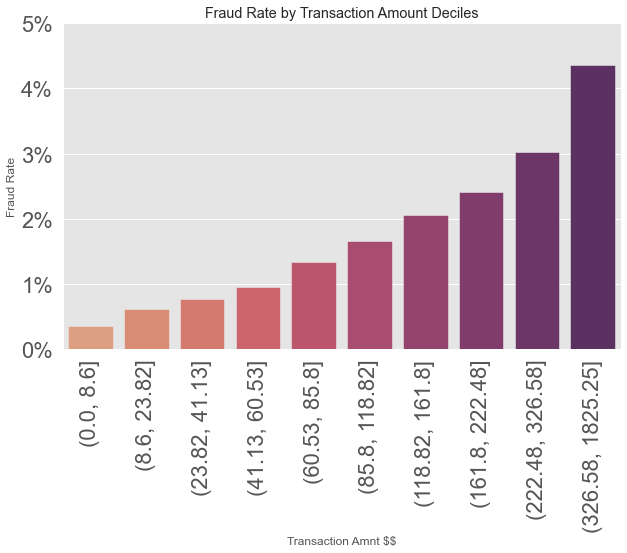

In [57]:
fig = plt.figure(figsize = (10,6))
g = sns.barplot(x='N-tile buckets', y='isFraud', data=ntile_dist(df, 'transactionAmount','isFraud', ntile=10).sort_index()
           , palette = "flare")
#plt.rcParams['xtick.labelsize'] = 10 
plt.xlabel('Transaction Amnt \$$')
plt.ylabel('Fraud Rate')
plt.ylim((0,5))
plt.xticks(rotation=90)
g.set_yticklabels(["0%", "1%","2%","3%","4%","5%"])
plt.title('Fraud Rate by Transaction Amount Deciles')
plt.show()

In [58]:
# fraud by current balance
ntile_dist(df,'availableMoney','isFraud', ntile=10)

,N-tile buckets,isFraud,pop
6,"(4892.646, 6964.601]",1.870950,10.000109
5,"(3578.165, 4892.646]",1.861632,9.999953
3,"(1514.42, 2388.614]",1.858516,9.999953
9,"(15000.0, 50000.0]",1.849548,9.517801
4,"(2388.614, 3578.165]",1.838264,9.999953
2,"(796.842, 1514.42]",1.838235,10.000109
8,"(9990.48, 15000.0]",1.704664,10.482106
1,"(305.31, 796.842]",1.674716,9.999797
7,"(6964.601, 9990.48]",1.588983,10.000109
0,"(-1244.93, 305.31]",1.528228,10.000109


In [59]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase
0,733493772,733493772,5000.0,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,01,rideshare,2020-04-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,0.00,0,0,9184733493772,2016-01-08,1900-01-01 19:04:50,2014,8,1,Jan,19,Friday,4PM_to_8PM,"(0, 5000]",Lyft,None,1,1
1,733493772,733493772,5000.0,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,01,rideshare,2023-06-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,111.33,0,0,9184733493772,2016-01-09,1900-01-01 22:32:39,2014,8,1,Jan,22,Saturday,8PM_to_12AM,"(0, 5000]",Uber,None,1,1
2,733493772,733493772,5000.0,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,01,rideshare,2027-12-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,0,136.08,0,0,9184733493772,2016-01-11,1900-01-01 13:36:55,2014,8,1,Jan,13,Monday,12PM_to_4PM,"(0, 5000]",Lyft,None,1,1
3,733493772,733493772,5000.0,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,02,01,rideshare,2029-09-01,2014-08-03,2014-08-03,492,492,9184,PURCHASE,1,323.48,0,0,9184733493772,2016-01-11,1900-01-01 22:47:46,2014,8,1,Jan,22,Monday,8PM_to_12AM,"(0, 5000]",Lyft,None,1,1
4,733493772,733493772,5000.0,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,02,01,rideshare,2024-10-01,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,0,550.82,0,0,9184733493772,2016-01-16,1900-01-01 01:41:11,2014,8,1,Jan,1,Saturday,12AM_to_4AM,"(0, 5000]",Lyft,None,1,1


# Section 3: Feature Engineering

### General transaction & customer info

- Account age - months since account opened [x]
- \# mnts since addresschange [x]
- \ # months remaining on the cards life[x]

- \# Day of the week transaction was made on [x]
- \# time of the day bucket [x]
- \# Month of purchase [x]


- are the customer and merchant from the same country?[x]
- is the account over drawn? [x]
- Hyatt House indicator. [x]

### Spend Behavior
- \# hours since last transaction by customer/card [x]
- \# hours since last transaction by merchant type by customer/card [x]
- (\\$ Transaction Amnt) / (\\$ avergae transaction amount in the last 7 transactions) [x]
- (\\$ Transaction Amnt) / (\\$ avergae transaction amount in the last 30 transactions) [x]
- (\\$ Transaction Amnt) / (\\$ Credit Limit) [x]
- (\\$ Transaction Amnt) / (\\$ Available Money) [x]


### Spend Velocity
- \# Number of transactions in the last 30mins [x]
- \# Number of transactions in the last 60mins [x]

In [60]:
# days since last transactions by customer/card
df = df.sort_values(['accountNumber', 'cardLast4Digits', 'transactionDateTime'])
df['hours_since_last_transaction'] = df.groupby(['accountNumber', 'cardLast4Digits'])['transactionDateTime'].diff()/pd.Timedelta(hours=1)
df['hours_since_last_transaction'] = df['hours_since_last_transaction'].fillna(0)
ntile_dist(df,'hours_since_last_transaction','isFraud', ntile=20)

,N-tile buckets,isFraud,pop
6,"(5.759, 7.872]",2.034838,5.056591
3,"(1.672, 2.72]",1.975447,5.057064
5,"(4.066, 5.759]",1.966161,5.056907
0,"(0.0, 0.223]",1.949648,3.911685
8,"(10.534, 13.838]",1.906839,5.057222
4,"(2.72, 4.066]",1.875565,5.057537
1,"(0.223, 0.855]",1.860277,5.056749
2,"(0.855, 1.672]",1.859987,5.057537
10,"(18.046, 23.494]",1.850698,5.057379
9,"(13.838, 18.046]",1.813254,5.057537


In [61]:
# days since last transactions by merchant type by customer/card 
df = df.sort_values(['accountNumber', 'cardLast4Digits', 'merchantCategoryCode', 'transactionDateTime'])
df['hours_since_last_merchant_type_transaction'] = df.groupby(['accountNumber', 'cardLast4Digits','merchantCategoryCode'])['transactionDateTime'].diff()/pd.Timedelta(hours=1)
df['hours_since_last_merchant_type_transaction'] = df['hours_since_last_merchant_type_transaction'].fillna(0)

In [62]:
# days since address change by customer/card
df = df.sort_values(['accountNumber', 'cardLast4Digits', 'transactionDateTime'])
df['mnts_since_address_change'] = ((df['transactionDateTime'] - df['dateOfLastAddressChange'])/np.timedelta64(1, 'M'))
df['mnts_since_address_change'] = df['mnts_since_address_change'].astype(float).fillna(0)
ntile_dist(df,'mnts_since_address_change','isFraud', ntile=20)

,N-tile buckets,isFraud,pop
2,"(0.528, 0.881]",2.137405,4.999899
8,"(4.967, 6.642]",2.106247,4.999899
7,"(3.734, 4.967]",2.043868,5.000055
4,"(1.35, 1.956]",1.953514,5.000055
3,"(0.881, 1.35]",1.891201,5.000055
0,"(0.000568, 0.242]",1.885029,4.999899
6,"(2.735, 3.734]",1.881854,5.000055
9,"(6.642, 8.72]",1.844467,5.000055
5,"(1.956, 2.735]",1.825830,4.999899
1,"(0.242, 0.528]",1.797732,5.000055


In [63]:
# account age
df['account_age'] = ((df['transactionDateTime'] - df['accountOpenDate'])/np.timedelta64(1, 'M'))
df['account_age'] = df['account_age'].astype(int)
ntile_dist(df,'account_age','isFraud', ntile=20)

,N-tile buckets,isFraud,pop
0,"(0.0, 5.0]",2.166976,5.136711
13,"(31.0, 35.0]",1.961137,6.073881
14,"(35.0, 39.0]",1.856209,4.777174
8,"(19.0, 21.0]",1.851341,4.528324
10,"(23.0, 26.0]",1.849858,5.654395
18,"(61.0, 76.0]",1.845779,4.998704
2,"(8.0, 10.0]",1.839982,5.455658
1,"(5.0, 8.0]",1.827970,6.234525
12,"(29.0, 31.0]",1.803554,3.531675
11,"(26.0, 29.0]",1.771530,5.463776


In [64]:
# create an indicator of the transaction number
df['transaction_number'] = 1

df['spent'] = df['creditLimit'] - df['availableMoney']

df = df.sort_values(['customerId'
                     , 'cardLast4Digits'
                     , 'transactionDateTime','spent']
                   )

df1 = df[['customerId', 'cardLast4Digits','transactionDateTime'
          ,'transaction_number']].groupby(['customerId'
                                           , 'cardLast4Digits'
                                           ,'transactionDateTime']
                                         ).sum().groupby(level=0).cumsum().reset_index()

df = df.drop('transaction_number', axis =1)

df = df.merge(df1, on = ['customerId'
                         , 'cardLast4Digits'
                         , 'transactionDateTime'])

del df1
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,transaction_number
0,100547107,100547107,2500.0,2500.00,2016-01-02 01:47:46,64.66,Popeyes #414406,US,US,09,01,fastfood,2030-02-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,0.00,1,0,1222100547107,2016-01-02,1900-01-01 01:47:46,2011,10,1,Jan,1,Saturday,12AM_to_4AM,"(0, 5000]",Popeyes,414406,1,1,0.000000,0.000000,50.106157,50,0.00,1
1,100547107,100547107,2500.0,2435.34,2016-01-16 23:35:41,5.31,Popeyes #700785,US,US,80,01,fastfood,2023-01-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,64.66,1,0,1222100547107,2016-01-16,1900-01-01 23:35:41,2011,10,1,Jan,23,Saturday,8PM_to_12AM,"(0, 5000]",Popeyes,700785,1,1,357.798611,357.798611,50.595967,50,64.66,2
2,100547107,100547107,2500.0,2430.03,2016-01-17 21:50:04,204.23,Arbys #46046,US,US,02,01,fastfood,2029-06-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,69.97,1,0,1222100547107,2016-01-17,1900-01-01 21:50:04,2011,10,1,Jan,21,Sunday,8PM_to_12AM,"(0, 5000]",Arbys,46046,1,1,22.239722,22.239722,50.626412,50,69.97,3
3,100547107,100547107,2500.0,2225.80,2016-01-29 05:19:50,155.28,Shake Shack #968081,US,US,05,08,fastfood,2020-12-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,274.20,1,0,1222100547107,2016-01-29,1900-01-01 05:19:50,2011,10,1,Jan,5,Friday,4AM_to_8AM,"(0, 5000]",Shake Shack,968081,1,1,271.496111,271.496111,50.998077,50,274.20,4
4,100547107,100547107,2500.0,2070.52,2016-01-30 20:49:10,91.14,In-N-Out #27394,US,US,09,01,fastfood,2027-01-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,429.48,1,0,1222100547107,2016-01-30,1900-01-01 20:49:10,2011,10,1,Jan,20,Saturday,8PM_to_12AM,"(0, 5000]",In-N-Out,27394,1,1,39.488889,39.488889,51.052136,51,429.48,5


In [65]:
## some interesting transactions that occur at the same exact time on a card
df[df[['customerId', 'cardLast4Digits'
       ,'transactionDateTime','transaction_number']].duplicated()]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,transaction_number
36330,170526539,170526539,7500.0,4205.68,2016-07-11 20:59:27,6.53,Auntie Anne's #622063,US,US,05,01,fastfood,2019-10-01,2015-06-26,2015-06-26,366,366,8321,PURCHASE,0,3294.32,1,0,8321170526539,2016-07-11,1900-01-01 20:59:27,2015,6,7,Jul,20,Monday,8PM_to_12AM,"(5000, 15000]",Auntie Anne's,622063,1,1,0.000000,0.000000,12.546446,12,3294.32,700
147285,318001076,318001076,50000.0,22117.84,2016-02-16 00:54:15,349.18,discount.com,US,US,05,99,online_retail,2030-07-01,2015-12-11,2016-02-15,633,633,1789,PURCHASE,0,27882.16,0,0,1789318001076,2016-02-16,1900-01-01 00:54:15,2015,12,2,Feb,0,Tuesday,12AM_to_4AM,"(15000, 50000]",discount.com,None,1,1,0.000000,0.000000,0.034093,2,27882.16,1263
150333,318001076,318001076,50000.0,26997.58,2016-06-06 09:15:41,13.12,gap.com,US,US,05,01,online_retail,2030-03-01,2015-12-11,2016-04-25,633,633,1789,PURCHASE,0,23002.42,0,0,1789318001076,2016-06-06,1900-01-01 09:15:41,2015,12,6,Jun,9,Monday,8AM_to_12PM,"(15000, 50000]",gap.com,None,1,1,0.000000,0.000000,1.392584,5,23002.42,4311
187470,356039230,356039230,7500.0,1365.66,2016-12-01 18:49:25,63.28,Lyft,US,US,09,08,rideshare,2031-11-01,2015-11-29,2016-07-18,917,917,9558,PURCHASE,0,6134.34,0,0,9558356039230,2016-12-01,1900-01-01 18:49:25,2015,11,12,Dec,18,Thursday,4PM_to_8PM,"(5000, 15000]",Lyft,None,1,1,0.000000,13.351111,4.494033,12,6134.34,1251
239403,428892294,428892294,2500.0,1534.41,2016-06-13 22:48:39,245.27,Mobile eCards,US,US,09,01,online_gifts,2018-10-01,2014-05-24,2016-05-02,654,654,4737,PURCHASE,0,965.59,1,0,4737428892294,2016-06-13,1900-01-01 22:48:39,2014,5,6,Jun,22,Monday,8PM_to_12AM,"(0, 5000]",Mobile eCards,None,1,1,0.000000,0.000000,1.411132,24,965.59,1319
240882,428892294,428892294,2500.0,664.70,2016-12-06 19:57:02,230.36,Mobile eCards,US,US,05,01,online_gifts,2025-11-01,2014-05-24,2016-08-02,654,654,4737,PURCHASE,0,1835.30,0,0,4737428892294,2016-12-06,1900-01-01 19:57:02,2014,5,12,Dec,19,Tuesday,4PM_to_8PM,"(0, 5000]",Mobile eCards,None,1,1,0.000000,0.000000,4.167027,30,1835.30,2798
258846,456044564,456044564,10000.0,4287.09,2016-07-12 17:27:11,100.46,Fresh Flowers,US,US,90,01,online_gifts,2022-07-01,2012-10-05,2016-07-05,746,746,5658,PURCHASE,0,5712.91,0,0,5658456044564,2016-07-12,1900-01-01 17:27:11,2012,10,7,Jul,17,Tuesday,4PM_to_8PM,"(5000, 15000]",Fresh Flowers,None,1,1,0.000000,123.651111,0.253877,45,5712.91,4409
389052,658700143,658700143,7500.0,2748.82,2016-09-10 08:04:52,115.93,ebay.com,US,US,09,01,online_retail,2024-02-01,2013-09-26,2016-07-26,506,506,2607,PURCHASE,0,4751.18,0,0,2607658700143,2016-09-10,1900-01-01 08:04:52,2013,9,9,Sep,8,Saturday,8AM_to_12PM,"(5000, 15000]",ebay.com,None,1,1,0.000000,0.000000,1.522387,35,4751.18,507
527584,833270526,833270526,500.0,139.04,2016-12-01 13:28:23,251.50,ebay.com,US,US,09,01,online_retail,2029-06-01,2012-04-18,2016-04-02,564,564,3545,PURCHASE,0,360.96,0,0,3545833270526,2016-12-01,1900-01-01 13:28:23,2012,4,12,Dec,13,Thursday,12PM_to_4PM,"(0, 5000]",ebay.com,None,1,1,12.233056,77.344167,8.002181,55,360.96,796


In [66]:
df[(df['accountNumber']=='170526539') & (df['transaction_number']==700)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,transaction_number
36329,170526539,170526539,7500.0,4415.35,2016-07-11 20:59:27,209.67,Krispy Kreme #920390,US,US,05,01,fastfood,2018-12-01,2015-06-26,2015-06-26,366,366,8321,PURCHASE,0,3084.65,1,0,8321170526539,2016-07-11,1900-01-01 20:59:27,2015,6,7,Jul,20,Monday,8PM_to_12AM,"(5000, 15000]",Krispy Kreme,920390,1,1,0.06,31.944167,12.546446,12,3084.65,700
36330,170526539,170526539,7500.0,4205.68,2016-07-11 20:59:27,6.53,Auntie Anne's #622063,US,US,05,01,fastfood,2019-10-01,2015-06-26,2015-06-26,366,366,8321,PURCHASE,0,3294.32,1,0,8321170526539,2016-07-11,1900-01-01 20:59:27,2015,6,7,Jul,20,Monday,8PM_to_12AM,"(5000, 15000]",Auntie Anne's,622063,1,1,0.00,0.000000,12.546446,12,3294.32,700


In [67]:
df[(df['accountNumber']=='318001076') & (df['transaction_number']==1263)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,transaction_number
147284,318001076,318001076,50000.0,22342.92,2016-02-16 00:54:15,225.08,ebay.com,US,US,05,01,online_retail,2028-04-01,2015-12-11,2016-02-15,633,633,1789,PURCHASE,0,27657.08,0,0,1789318001076,2016-02-16,1900-01-01 00:54:15,2015,12,2,Feb,0,Tuesday,12AM_to_4AM,"(15000, 50000]",ebay.com,None,1,1,1.818056,2.368056,0.034093,2,27657.08,1263
147285,318001076,318001076,50000.0,22117.84,2016-02-16 00:54:15,349.18,discount.com,US,US,05,99,online_retail,2030-07-01,2015-12-11,2016-02-15,633,633,1789,PURCHASE,0,27882.16,0,0,1789318001076,2016-02-16,1900-01-01 00:54:15,2015,12,2,Feb,0,Tuesday,12AM_to_4AM,"(15000, 50000]",discount.com,None,1,1,0.000000,0.000000,0.034093,2,27882.16,1263


In [68]:
# df1 = df.groupby(['customerId'
#                   , 'cardLast4Digits'
#                  ]
#                 )['transactionAmount'].rolling(30).mean().reset_index()
# df['rolling_30_transaction_amt'] = df1['transactionAmount']
# del df1

In [69]:
delta = 1800
velocity = 'num_transactions_in_last_'+str(delta/60)+'_mins'
delta =str(delta)+'s'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime']].copy()
df[velocity]= (df1.set_index('transactionDateTime'
                            ).assign(count_last=1
                                    ).groupby(['customerId', 'cardLast4Digits']
                                             ).rolling(delta
                                                      ).sum() - 1
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['count_last']
del df1

# fraud by velocity
categoryPercCounts(velocity, 'isFraud', df, tolerance = 1000)

,num_transactions_in_last_30.0_mins,pop,isFraud,popPerc
2,2.0,3941,2.080690,0.614511
1,1.0,35247,1.875337,5.495983
0,0.0,602135,1.751933,93.889507


In [70]:
delta = 3600
velocity = 'num_transactions_in_last_'+str(delta/60)+'_mins'
delta =str(delta)+'s'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime']].copy()
df[velocity]= (df1.set_index('transactionDateTime'
                            ).assign(count_last=1
                                    ).groupby(['customerId', 'cardLast4Digits']
                                             ).rolling(delta
                                                      ).sum() - 1
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['count_last']
del df1

# fraud by velocity
categoryPercCounts(velocity, 'isFraud', df, tolerance = 1000)

,num_transactions_in_last_60.0_mins,pop,isFraud,popPerc
1,1.0,51481,1.886133,8.027725
3,3.0,2023,1.878398,0.315458
2,2.0,9074,1.818382,1.414960
0,0.0,578712,1.747329,90.241856


<Figure size 1440x720 with 0 Axes>

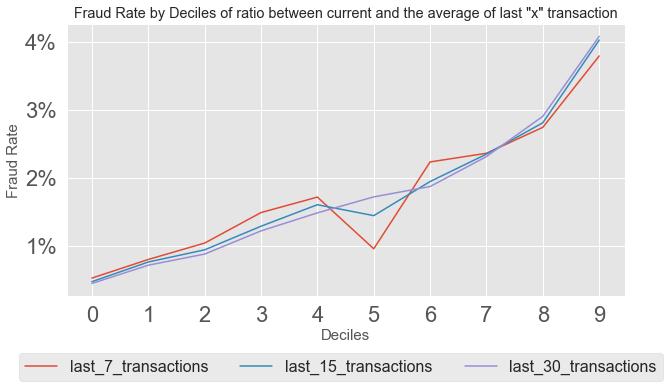

In [71]:
delta = 7
spendAvg = 'last_'+str(delta)+'_transactions'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime', 'transactionAmount']].copy()
df[spendAvg]= (df1.set_index('transactionDateTime'
                            ).groupby(['customerId', 'cardLast4Digits']
                                     ).rolling(f'{delta}D'
                                              ).mean()
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['transactionAmount']
del df1
# create spend over avergae
spendOverAvg = spendAvg
df[spendOverAvg] = (df['transactionAmount']/df[spendAvg]).fillna(0)

temp = ntile_dist(df
                  , spendOverAvg
                  ,'isFraud'
                  , ntile=10).sort_index()[['N-tile buckets'
                                            ,'isFraud']]
temp.columns = ['N-tile buckets',spendOverAvg]
delta = 15
spendAvg = 'last_'+str(delta)+'_transactions'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime', 'transactionAmount']].copy()
df[spendAvg]= (df1.set_index('transactionDateTime'
                            ).groupby(['customerId', 'cardLast4Digits']
                                     ).rolling(f'{delta}D'
                                              ).mean()
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['transactionAmount']
del df1
# create spend over avergae
spendOverAvg = spendAvg
df[spendOverAvg] = (df['transactionAmount']/df[spendAvg]).fillna(0)
temp[spendOverAvg] = ntile_dist(df
                                , spendOverAvg
                                ,'isFraud'
                                , ntile=10).sort_index()['isFraud']

delta = 30
spendAvg = 'last_'+str(delta)+'_transactions'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime', 'transactionAmount']].copy()
df[spendAvg]= (df1.set_index('transactionDateTime'
                            ).groupby(['customerId', 'cardLast4Digits']
                                     ).rolling(f'{delta}D'
                                              ).mean()
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['transactionAmount']
del df1
# create spend over avergae
spendOverAvg = spendAvg
df[spendOverAvg] = (df['transactionAmount']/df[spendAvg]).fillna(0)
temp[spendOverAvg] = ntile_dist(df
                                , spendOverAvg
                                ,'isFraud'
                                , ntile=10).sort_index()['isFraud']

temp['Decile'] = [0,1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,10))
ax = temp.plot(x='Decile', y=['last_7_transactions'
                         , 'last_15_transactions'
                         , 'last_30_transactions'], figsize=(10,5), grid=True)
plt.xticks(temp['Decile'], range(10))
plt.xlabel("Deciles", fontsize=15)
plt.ylabel("Fraud Rate", fontsize=15)
plt.legend(loc='upper left', ncol = 3, bbox_to_anchor=(-0.1, -0.18)
           , prop={'size': 16})
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title('Fraud Rate by Deciles of ratio between current and the average of last "x" transaction')
plt.show()


In [72]:
## just checking everything is working well
df.loc[:,['customerId','cardLast4Digits','transactionDateTime', 'transactionAmount'
          , velocity
          , spendAvg
          , spendOverAvg
          , 'isFraud']].head(20)

,customerId,cardLast4Digits,transactionDateTime,transactionAmount,num_transactions_in_last_60.0_mins,last_30_transactions,last_30_transactions,isFraud
0,100547107,1222,2016-01-02 01:47:46,64.66,0.0,1.000000,1.000000,0
1,100547107,1222,2016-01-16 23:35:41,5.31,0.0,0.151779,0.151779,0
2,100547107,1222,2016-01-17 21:50:04,204.23,0.0,2.234464,2.234464,0
3,100547107,1222,2016-01-29 05:19:50,155.28,0.0,1.446214,1.446214,0
4,100547107,1222,2016-01-30 20:49:10,91.14,0.0,0.875303,0.875303,0
5,100547107,1222,2016-02-06 22:31:44,2.80,0.0,0.030517,0.030517,0
6,100547107,1222,2016-02-10 06:48:23,119.77,0.0,1.242148,1.242148,0
7,100547107,1222,2016-02-11 08:28:07,211.11,0.0,1.871448,1.871448,0
8,100547107,1222,2016-02-20 01:01:47,66.23,0.0,0.614825,0.614825,0
9,100547107,1222,2016-02-26 04:02:55,1.06,0.0,0.011461,0.011461,0


In [73]:
print(df[df['availableMoney']>=0]['isFraud'].mean()*100)
print(df[df['availableMoney']<0]['isFraud'].mean()*100)

1.7617624193848613
1.493680582152432


In [74]:
df['overDrawn'] = (df['availableMoney']<0).astype(int)

In [75]:
df['transaction_CL_ratio'] = df['transactionAmount']/df['creditLimit']
df['transaction_AvailMoney_ratio'] = df['transactionAmount']/df['availableMoney']

In [76]:
df['HyattHouse_flag'] = (df['merchantName_name']=='Hyatt House').astype(int)

In [77]:
# account age
df['remaining_life_on_card'] = ((df['currentExpDate'] - df['transactionDateTime'])/np.timedelta64(1, 'M'))
df['remaining_life_on_card'] = df['remaining_life_on_card'].astype(int)
ntile_dist(df,'remaining_life_on_card','isFraud', ntile=20)

,N-tile buckets,isFraud,pop
5,"(63.0, 71.0]",1.974463,4.868128
18,"(169.0, 178.0]",1.912040,5.483323
17,"(161.0, 169.0]",1.895796,4.831830
10,"(104.0, 112.0]",1.854507,4.889003
2,"(38.0, 46.0]",1.845616,4.904114
12,"(120.0, 128.0]",1.807443,4.826689
3,"(46.0, 54.0]",1.784351,4.897883
13,"(128.0, 137.0]",1.763997,5.431291
16,"(153.0, 161.0]",1.753257,4.842579
14,"(137.0, 145.0]",1.752874,4.879189


### clean up for modeling

In [78]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,CC_ID,transactionDate,transactionTime,accountOpenDate_year,accountOpenDate_mnt,transactionDate_mnt,transactionDate_mnt_name,transactionDate_Hour,transactionDate_weekday_name,time_of_day_buckets,creditLimit_buckets,merchantName_name,merchantName_id,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,transaction_number,num_transactions_in_last_30.0_mins,num_transactions_in_last_60.0_mins,last_7_transactions,last_15_transactions,last_30_transactions,overDrawn,transaction_CL_ratio,transaction_AvailMoney_ratio,HyattHouse_flag,remaining_life_on_card
0,100547107,100547107,2500.0,2500.00,2016-01-02 01:47:46,64.66,Popeyes #414406,US,US,09,01,fastfood,2030-02-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,0.00,1,0,1222100547107,2016-01-02,1900-01-01 01:47:46,2011,10,1,Jan,1,Saturday,12AM_to_4AM,"(0, 5000]",Popeyes,414406,1,1,0.000000,0.000000,50.106157,50,0.00,1,0.0,0.0,1.000000,1.000000,1.000000,0,0.025864,0.025864,0,169
1,100547107,100547107,2500.0,2435.34,2016-01-16 23:35:41,5.31,Popeyes #700785,US,US,80,01,fastfood,2023-01-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,64.66,1,0,1222100547107,2016-01-16,1900-01-01 23:35:41,2011,10,1,Jan,23,Saturday,8PM_to_12AM,"(0, 5000]",Popeyes,700785,1,1,357.798611,357.798611,50.595967,50,64.66,2,0.0,0.0,1.000000,0.151779,0.151779,0,0.002124,0.002180,0,83
2,100547107,100547107,2500.0,2430.03,2016-01-17 21:50:04,204.23,Arbys #46046,US,US,02,01,fastfood,2029-06-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,69.97,1,0,1222100547107,2016-01-17,1900-01-01 21:50:04,2011,10,1,Jan,21,Sunday,8PM_to_12AM,"(0, 5000]",Arbys,46046,1,1,22.239722,22.239722,50.626412,50,69.97,3,0.0,0.0,1.949318,1.949318,2.234464,0,0.081692,0.084044,0,160
3,100547107,100547107,2500.0,2225.80,2016-01-29 05:19:50,155.28,Shake Shack #968081,US,US,05,08,fastfood,2020-12-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,274.20,1,0,1222100547107,2016-01-29,1900-01-01 05:19:50,2011,10,1,Jan,5,Friday,4AM_to_8AM,"(0, 5000]",Shake Shack,968081,1,1,271.496111,271.496111,50.998077,50,274.20,4,0.0,0.0,1.000000,1.276904,1.446214,0,0.062112,0.069764,0,58
4,100547107,100547107,2500.0,2070.52,2016-01-30 20:49:10,91.14,In-N-Out #27394,US,US,09,01,fastfood,2027-01-01,2011-10-30,2011-10-30,786,786,1222,PURCHASE,0,429.48,1,0,1222100547107,2016-01-30,1900-01-01 20:49:10,2011,10,1,Jan,20,Saturday,8PM_to_12AM,"(0, 5000]",In-N-Out,27394,1,1,39.488889,39.488889,51.052136,51,429.48,5,0.0,0.0,0.739713,0.799544,0.875303,0,0.036456,0.044018,0,131


In [79]:
# config - feature list
numeric_cols = ['creditLimit','availableMoney','transactionAmount'
                , 'isFraud', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch'
                , 'cardCVVMatch', 'DomesticPurchase', 'hours_since_last_transaction'
                , 'hours_since_last_merchant_type_transaction', 'mnts_since_address_change'
                , 'account_age', 'spent'
                , 'num_transactions_in_last_30.0_mins'
                , 'last_15_transactions'
                , 'last_30_transactions'
                , 'overDrawn', 'transaction_CL_ratio'
                , 'transaction_AvailMoney_ratio'
                , 'remaining_life_on_card'
               ]

categorical_cols = ['posEntryMode', 'posConditionCode'
                    , 'merchantCategoryCode', 'transactionType'
                    , 'transactionDate_mnt_name'
                    , 'transactionDate_weekday_name'
                    , 'time_of_day_buckets'
                   ]

merchantName_col = ['merchantName_name']

In [80]:
## convert categorical to numerical
df = pd.concat([df.loc[:,numeric_cols],pd.get_dummies(df.loc[:,categorical_cols])], axis = 1)
print(df.shape)
df.head()

(641914, 79)


,creditLimit,availableMoney,transactionAmount,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cardCVVMatch,DomesticPurchase,hours_since_last_transaction,hours_since_last_merchant_type_transaction,mnts_since_address_change,account_age,spent,num_transactions_in_last_30.0_mins,last_15_transactions,last_30_transactions,overDrawn,transaction_CL_ratio,transaction_AvailMoney_ratio,remaining_life_on_card,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posEntryMode_missing,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_missing,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_missing,transactionDate_mnt_name_Apr,transactionDate_mnt_name_Aug,transactionDate_mnt_name_Dec,transactionDate_mnt_name_Feb,transactionDate_mnt_name_Jan,transactionDate_mnt_name_Jul,transactionDate_mnt_name_Jun,transactionDate_mnt_name_Mar,transactionDate_mnt_name_May,transactionDate_mnt_name_Nov,transactionDate_mnt_name_Oct,transactionDate_mnt_name_Sep,transactionDate_weekday_name_Friday,transactionDate_weekday_name_Monday,transactionDate_weekday_name_Saturday,transactionDate_weekday_name_Sunday,transactionDate_weekday_name_Thursday,transactionDate_weekday_name_Tuesday,transactionDate_weekday_name_Wednesday,time_of_day_buckets_12AM_to_4AM,time_of_day_buckets_12PM_to_4PM,time_of_day_buckets_4AM_to_8AM,time_of_day_buckets_4PM_to_8PM,time_of_day_buckets_8AM_to_12PM,time_of_day_buckets_8PM_to_12AM
0,2500.0,2500.00,64.66,0,0.00,1,0,1,1,0.000000,0.000000,50.106157,50,0.00,0.0,1.000000,1.000000,0,0.025864,0.025864,169,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,2500.0,2435.34,5.31,0,64.66,1,0,1,1,357.798611,357.798611,50.595967,50,64.66,0.0,0.151779,0.151779,0,0.002124,0.002180,83,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,2500.0,2430.03,204.23,0,69.97,1,0,1,1,22.239722,22.239722,50.626412,50,69.97,0.0,1.949318,2.234464,0,0.081692,0.084044,160,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,2500.0,2225.80,155.28,0,274.20,1,0,1,1,271.496111,271.496111,50.998077,50,274.20,0.0,1.276904,1.446214,0,0.062112,0.069764,58,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,2500.0,2070.52,91.14,0,429.48,1,0,1,1,39.488889,39.488889,51.052136,51,429.48,0.0,0.799544,0.875303,0,0.036456,0.044018,131,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [81]:
from sklearn.base import BaseEstimator, TransformerMixin
import logging
class CorrReduction(BaseEstimator, TransformerMixin):
	"""
	Identify highly correlated features.
	Only keep the feature more correlated to the target.
    
    Author: Prabhat R.
	"""

	def __init__(self, threshold = 0.9, corr_method ='spearman'):
		self.threshold = threshold
		self.corr_method = corr_method

	def fit(self, X, y=None):
		logging.info("**********Removing Highly Correlated Features**********")
		temp = pd.concat([X,y], axis = 1)
		temp.columns = list(X.columns) + ['target']
		corr_matrix = temp.corr(method = self.corr_method)
		corr_matrix_ = corr_matrix.copy()
		np.fill_diagonal(corr_matrix_.values, np.nan)
		corr_matrix_ = pd.DataFrame(corr_matrix_)
		corr_matrix_.columns = temp.columns
		corr_matrix_.index =  temp.columns
		corr_matrix_.drop('target', axis = 0, inplace = True)
		target_var = corr_matrix_.loc[:, 'target']
		corr_matrix_.drop('target', axis = 1, inplace = True)
		# Only keep the upper part of the corr matrix.
		corr_matrix_ = corr_matrix_.where(np.triu(np.ones(corr_matrix_.shape)).astype(np.bool))
		corr_matrix_ = np.where(corr_matrix_ >= self.threshold, 1, 0)
		corr_matrix_ = pd.DataFrame(corr_matrix_)
		corr_matrix_.columns = X.columns
		corr_matrix_.index =  X.columns
		col_ls = list(X.columns)
		# Persist a variable exclusion dict
		self.remove_dict = {}
		remove_ls = []
		# TODO: change logic its dog shit and slow.
		for col in col_ls:
			if col not in remove_ls:
				target_corr = target_var.loc[col]
				temp_dict = {}
				temp_rm = []
				for other_col in col_ls:
					if other_col not in remove_ls:
						if (corr_matrix_.loc[col, other_col]==1):
							if target_var.loc[other_col]>=target_corr:
								remove_ls.append(col)
								self.remove_dict[col] = other_col
								temp_rm = []
								temp_dict = {}
								break
							else:
								temp_rm.append(other_col)
								temp_dict[other_col] = col
				remove_ls = remove_ls + temp_rm
				self.remove_dict.update(temp_dict)
		return self
# TODO : Add transform to use with sklearn pipelines

In [82]:
corrRed = CorrReduction(threshold = 0.9)
corrRed.fit(df.drop('isFraud', axis = 1), y = df.loc[:,'isFraud'])
len(corrRed.remove_dict.keys())

3

In [83]:
# keys are drop suggestion and values are the reason for the drop
corrRed.remove_dict

{'last_30_transactions': 'transactionAmount',
 'spent': 'currentBalance',
 'transaction_AvailMoney_ratio': 'transaction_CL_ratio'}

In [84]:
df = df.drop(list(corrRed.remove_dict.keys()), axis = 1)

# Section 4: Models

In [85]:
# build set - test set creation
# usually data tranches are better but theres only a years worth of data so lets go with random?
build_x, test_x, build_y, test_y = train_test_split(df.drop('isFraud', axis = 1)
                                                    , df['isFraud']
                                                    , stratify=  df['isFraud']
                                                    , test_size = 0.25
                                                    , random_state = 66)
print(f"Build set fraud rate {100*build_y.sum()/build_x.shape[0]}%")
print(f"Test set fraud rate {100*test_y.sum()/test_x.shape[0]}%")

Build set fraud rate 1.7605699627156315%
Test set fraud rate 1.7609780718972576%


In [86]:
print(build_x.shape)
print(test_x.shape)

(481435, 75)
(160479, 75)


# Section 4.1: Baseline Models

- Lets create quick baseline models to set a lower bound on performance to beat

- since these two vars were sloping Fraud risk pretty well over deciles, lets use them
- spend over average spend in last 15 days 
- transaction amount to credit limit

In [87]:
print(f"AUC-ROC when using spenOverAvg to predict Fraud : {round(roc_auc_score(test_y, test_x['last_15_transactions']),3)}")
print(f"AUC-ROC when using spend_CL_ratio to predict Fraud : {round(roc_auc_score(test_y, test_x['transaction_CL_ratio']),3)}")
print(f"AUC-ROC when using transaction amount to predict Fraud : {round(roc_auc_score(test_y, test_x['transactionAmount']),3)}")

AUC-ROC when using spenOverAvg to predict Fraud : 0.66
AUC-ROC when using spend_CL_ratio to predict Fraud : 0.622
AUC-ROC when using transaction amount to predict Fraud : 0.687


In [88]:
# not too shabby
# lets create decile cuts for these two models

In [89]:
ntile = 10
ntile_list_spendOverAvg = [0]
nvar = int(100/ntile)
for i in range(1,ntile+1):
    a = (np.percentile(build_x['last_15_transactions'], nvar*i))
    ntile_list_spendOverAvg.insert(len(ntile_list_spendOverAvg),a)
ntile_list_spendOverAvg[-1] = 100

ntile_list_spendOverAvg

[0,
 0.09036926509002374,
 0.23351248244816492,
 0.3972460335682179,
 0.5909853955646249,
 0.8218142316758427,
 0.9999999999994579,
 1.2054261637314685,
 1.594479662092447,
 2.1687502506943157,
 100]

In [90]:
ntile = 10
ntile_list_spend_CL_ratio = [0]
nvar = int(100/ntile)
for i in range(1,ntile+1):
    a = (np.percentile(build_x['transaction_CL_ratio'], nvar*i))
    ntile_list_spend_CL_ratio.insert(len(ntile_list_spend_CL_ratio),a)
ntile_list_spend_CL_ratio[-1] = 100

ntile_list_spend_CL_ratio

[0,
 0.0009235999999999999,
 0.0025453333333333335,
 0.00468,
 0.007610866666666669,
 0.01172,
 0.01780666666666667,
 0.027684,
 0.047133999999999995,
 0.11271120000000043,
 100]

In [91]:
## scrapped
## Tried to build a simple model on velocity and spend over transaction but it performed just as well as spend over transaction
##
# set_scale_pos_wts = (sum(build_y==1)/sum(build_y==0))

# xgb_params = {'max_depth': 2
#               , 'colsample_bytree': 1
#               , 'objective': 'binary:logistic'
#               , 'scale_pos_weight': set_scale_pos_wts
#               , 'random_state': 42}

# DTrain = xgboost.DMatrix(build_x.loc[:,['num_transactions_in_last_30.0_mins'
#                                         ,'spend_over_avg_transactions_in_last_15_days']]
#                          , build_y)

# bst_rounds = xgboost.cv(xgb_params
#                         , DTrain
#                         , num_boost_round = 1500
#                         , nfold = 5
#                         , stratified = True
#                         , metrics = 'auc'
#                         , early_stopping_rounds = 50
#                         , seed = 42
#                         , verbose_eval = True)

# best_num_booster = bst_rounds.index.max()
# del xgb_params
# del best_rounds
# del DTrain

# Section 4.2: Contender Model

In [92]:
set_scale_pos_wts = (sum(build_y==1)/sum(build_y==0))

xgb_params = {'max_depth': 3
              , 'colsample_bytree': 0.8
              , 'objective': 'binary:logistic'
              , 'scale_pos_weight': set_scale_pos_wts
              , 'random_state': 42
              , 'n_jobs': 6
             }

DTrain = xgboost.DMatrix(build_x
                         , build_y)

bst_rounds = xgboost.cv(xgb_params
                        , DTrain
                        , num_boost_round = 1500
                        , nfold = 5
                        , stratified = True
                        , metrics = 'auc'
                        , early_stopping_rounds = 50
                        , seed = 42
                        , verbose_eval = True)

best_num_booster = bst_rounds.index.max()

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[1]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[2]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[3]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[4]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[5]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[6]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[7]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[8]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[9]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[10]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[11]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[12]	train-auc:0.60443+0.05225	test-auc:0.60237+0.05160
[13]	train-auc:0.64472+0.00701	test-auc:0.64215+0.00936
[14]	train-auc:0.65749+0.00952	test-auc:0.65437+0.01082
[15]	train-auc:0.67006+0.01455	test-auc:0.66524+0.01078
[16]	train-auc:0.68258+0.01719	test-auc:0.67917+0.01941
[17]	train-auc:0.68988+0.01496	test-auc:0.68565+0.01941
[1

[146]	train-auc:0.78752+0.00101	test-auc:0.76411+0.00347
[147]	train-auc:0.78775+0.00099	test-auc:0.76426+0.00348
[148]	train-auc:0.78790+0.00099	test-auc:0.76417+0.00352
[149]	train-auc:0.78808+0.00092	test-auc:0.76424+0.00357
[150]	train-auc:0.78818+0.00091	test-auc:0.76422+0.00359
[151]	train-auc:0.78834+0.00090	test-auc:0.76426+0.00363
[152]	train-auc:0.78851+0.00086	test-auc:0.76433+0.00372
[153]	train-auc:0.78871+0.00085	test-auc:0.76431+0.00370
[154]	train-auc:0.78889+0.00087	test-auc:0.76434+0.00374
[155]	train-auc:0.78904+0.00087	test-auc:0.76434+0.00371
[156]	train-auc:0.78923+0.00088	test-auc:0.76433+0.00376
[157]	train-auc:0.78942+0.00091	test-auc:0.76438+0.00372
[158]	train-auc:0.78957+0.00091	test-auc:0.76437+0.00382
[159]	train-auc:0.78966+0.00090	test-auc:0.76425+0.00377
[160]	train-auc:0.78983+0.00088	test-auc:0.76425+0.00382
[161]	train-auc:0.78997+0.00091	test-auc:0.76424+0.00390
[162]	train-auc:0.79013+0.00084	test-auc:0.76423+0.00386
[163]	train-auc:0.79030+0.00079

[290]	train-auc:0.80544+0.00057	test-auc:0.76485+0.00469
[291]	train-auc:0.80553+0.00060	test-auc:0.76483+0.00471
[292]	train-auc:0.80560+0.00058	test-auc:0.76485+0.00472
[293]	train-auc:0.80567+0.00060	test-auc:0.76479+0.00472
[294]	train-auc:0.80578+0.00058	test-auc:0.76480+0.00470
[295]	train-auc:0.80586+0.00054	test-auc:0.76475+0.00469
[296]	train-auc:0.80592+0.00052	test-auc:0.76476+0.00473
[297]	train-auc:0.80600+0.00052	test-auc:0.76477+0.00469
[298]	train-auc:0.80612+0.00053	test-auc:0.76471+0.00467
[299]	train-auc:0.80625+0.00054	test-auc:0.76465+0.00464


In [93]:
del bst_rounds
print(f"Best number of boosters : {best_num_booster}")
xgb_ = xgboost.train(xgb_params
                     , DTrain
                     , num_boost_round = best_num_booster)
model_bytearray = xgb_.save_raw()[4:]
def tempfunc(self=None):
    return model_bytearray
xgb_.save_raw = tempfunc
explainer = shap.TreeExplainer(xgb_)
shap_values = explainer.shap_values(DTrain)
del DTrain

Best number of boosters : 250
[16:47:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


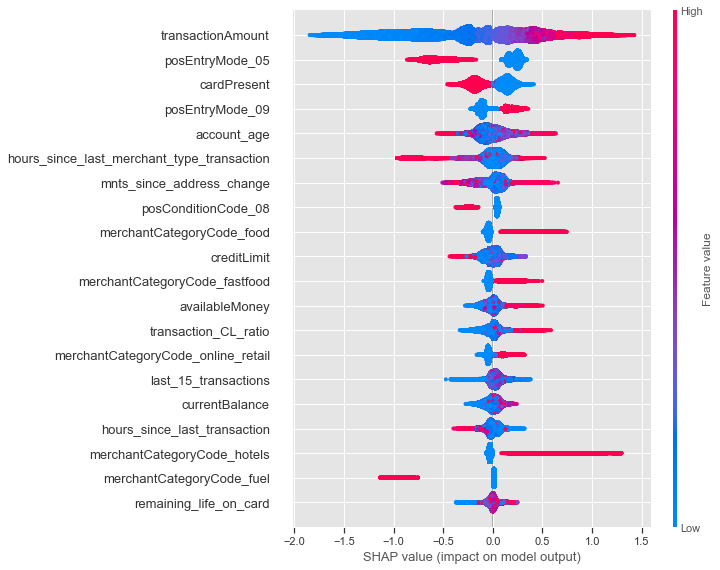

In [94]:
shap.summary_plot(shap_values, features = build_x
                  , feature_names = build_x.columns)

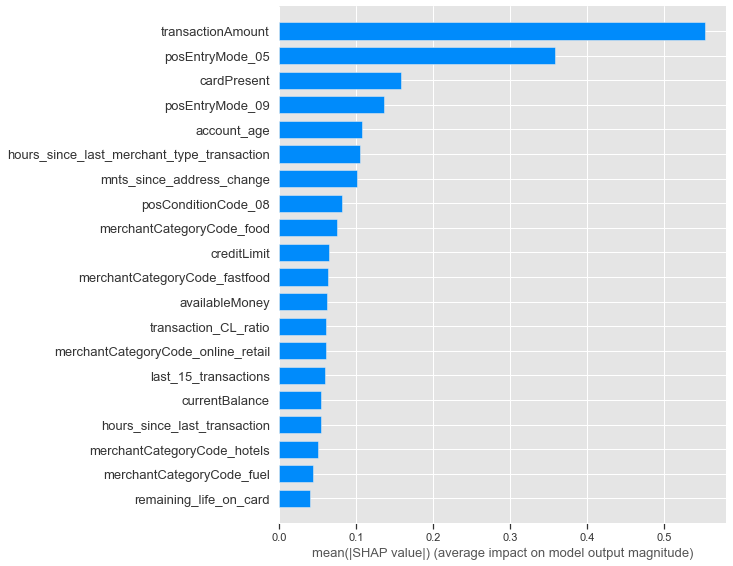

In [95]:
shap.summary_plot(shap_values, df.drop('isFraud', axis = 1), plot_type="bar")

In [96]:
shap_sum = np.abs(shap_values).mean(axis = 0)
feat_importance = pd.DataFrame([df.drop('isFraud', axis = 1).columns.tolist(), shap_sum.tolist()]).T
feat_importance.columns = ['column_names','shap_imp']
feat_importance = feat_importance.sort_values('shap_imp', ascending = False)
print(feat_importance.shape)
feat_importance = feat_importance[feat_importance['shap_imp']>0]
print(feat_importance.shape)

(75, 2)
(54, 2)


In [97]:
# what got dropped ?
feat_dropped = pd.DataFrame([df.drop('isFraud', axis = 1).columns.tolist(), shap_sum.tolist()]).T
feat_dropped.columns = ['column_names','shap_imp']
feat_dropped = feat_dropped.sort_values('shap_imp', ascending = False)
feat_dropped = feat_dropped[feat_dropped['shap_imp']==0]
feat_dropped

,column_names,shap_imp
54,transactionDate_mnt_name_Jan,0
17,posEntryMode_02,0
48,transactionType_REVERSAL,0
72,time_of_day_buckets_4PM_to_8PM,0
5,expirationDateKeyInMatch,0
7,DomesticPurchase,0
12,num_transactions_in_last_30.0_mins,0
14,overDrawn,0
67,transactionDate_weekday_name_Tuesday,0
49,transactionType_missing,0


In [98]:
#features_importance_list = list(feat_importance.loc[:,'column_names'])

In [99]:
features_importance_list = list(feat_importance.loc[:,'column_names'])
auc_num_feats_val = {}
auc_num_feats_train = {}
top_feats = 1
feat_ls = features_importance_list[0:top_feats]
auc_num_feats_val['auc'] = {}
auc_num_feats_val['auc_std'] = {}
while len(feat_ls)<=250:
    print(f"Building model with {top_feats} Variable(s).")
    feat_ls = features_importance_list[0:top_feats]
    set_scale_pos_wts = (sum(build_y==1)/sum(build_y==0))
    xgb_params = {'max_depth': 3
                  , 'colsample_bytree': 0.8
                  , 'objective': 'binary:logistic'
                  , 'scale_pos_weight': set_scale_pos_wts
                  , 'random_state': 42
                  , 'n_jobs': 6
                  #, 'nthreads':-1
                 }
    DTrain = xgboost.DMatrix(build_x.loc[:,feat_ls], build_y)
    bst_rounds = xgboost.cv(xgb_params
                            , DTrain
                            , num_boost_round = 1500
                            , nfold = 5
                            , stratified = True
                            , metrics = 'auc'
                            , early_stopping_rounds = 50
                            , seed = 42
                            , verbose_eval = False
                            )
    del DTrain
    auc_num_feats_val['auc'][len(feat_ls)] = bst_rounds.tail(1).iloc[0]['test-auc-mean']
    auc_num_feats_val['auc_std'][len(feat_ls)] = bst_rounds.tail(1).iloc[0]['test-auc-std']
    auc_num_feats_train[len(feat_ls)] = bst_rounds.tail(1).iloc[0]['train-auc-mean']
    if len(feat_ls)<=10:
        top_feats = top_feats + 1
    elif len(feat_ls)<=50:
        top_feats = top_feats + 4
    else:
        top_feats = top_feats + 9
    del bst_rounds
    if top_feats >= len(features_importance_list):
        break

Building model with 1 Variable(s).
Building model with 2 Variable(s).
Building model with 3 Variable(s).
Building model with 4 Variable(s).
Building model with 5 Variable(s).
Building model with 6 Variable(s).
Building model with 7 Variable(s).
Building model with 8 Variable(s).
Building model with 9 Variable(s).
Building model with 10 Variable(s).
Building model with 11 Variable(s).
Building model with 15 Variable(s).
Building model with 19 Variable(s).
Building model with 23 Variable(s).
Building model with 27 Variable(s).
Building model with 31 Variable(s).
Building model with 35 Variable(s).
Building model with 39 Variable(s).
Building model with 43 Variable(s).
Building model with 47 Variable(s).
Building model with 51 Variable(s).


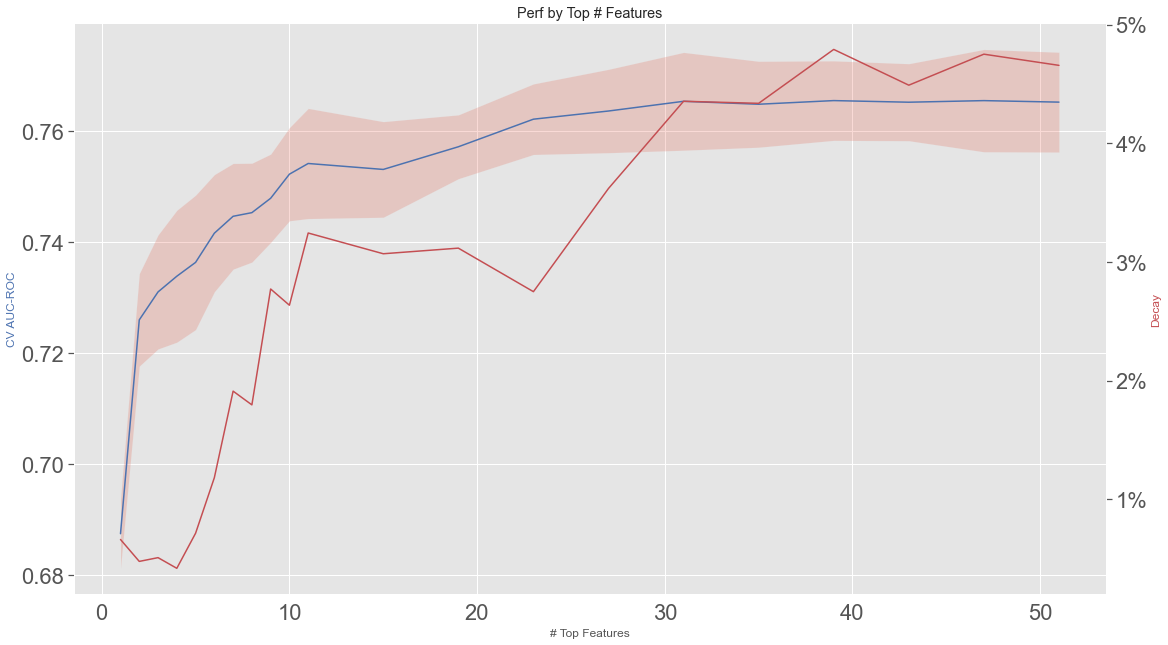

In [100]:
auc_num_feats_val['std_low'] = {}
auc_num_feats_val['std_high'] = {}
auc_num_feats_val['decay'] = {}
for num_feat in auc_num_feats_val['auc'].keys():
    auc_num_feats_val['std_low'][num_feat] = auc_num_feats_val['auc'][num_feat] - 2*auc_num_feats_val['auc_std'][num_feat]
    auc_num_feats_val['std_high'][num_feat] = auc_num_feats_val['auc'][num_feat] + 2*auc_num_feats_val['auc_std'][num_feat]
    auc_num_feats_val['decay'][num_feat] = (100*(auc_num_feats_train[num_feat]-auc_num_feats_val['auc'][num_feat]))/auc_num_feats_train[num_feat]

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5,10.5, forward = True)
ax2 = ax1.twinx()
ax1.plot(list(auc_num_feats_val['auc'].keys()), list(auc_num_feats_val['auc'].values()), 'b-')
ax1.fill_between(list(auc_num_feats_val['std_low'].keys()), list(auc_num_feats_val['std_low'].values())
                 , list(auc_num_feats_val['std_high'].values()), alpha = 0.2)
ax2.plot(list(auc_num_feats_val['decay'].keys()), list(auc_num_feats_val['decay'].values()), 'r-')
ax1.set_xlabel("# Top Features")
ax1.set_ylabel("CV AUC-ROC", color = "b", fontsize = "large")
ax2.set_ylabel("Decay", color = "r", fontsize = "large")
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick) 
plt.title("Perf by Top # Features")
plt.grid()
plt.show()

In [101]:
# looks like top 25 is enough 
final_red_ls = features_importance_list[0:25]
set_scale_pos_wts = (sum(build_y==1)/sum(build_y==0))

xgb_params = {'max_depth': 3
              , 'colsample_bytree': 0.8
              , 'objective': 'binary:logistic'
              , 'scale_pos_weight': set_scale_pos_wts
              , 'random_state': 42}

DTrain = xgboost.DMatrix(build_x.loc[:, final_red_ls]
                         , build_y)

bst_rounds = xgboost.cv(xgb_params
                        , DTrain
                        , num_boost_round = 1500
                        , nfold = 5
                        , stratified = True
                        , metrics = 'auc'
                        , early_stopping_rounds = 50
                        , seed = 42
                        , verbose_eval = True)

best_num_booster = bst_rounds.index.max()

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[1]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[2]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[3]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[4]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[5]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[6]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[7]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[8]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[9]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[10]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[11]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[12]	train-auc:0.57562+0.06186	test-auc:0.57413+0.06078
[13]	train-auc:0.64152+0.00882	test-auc:0.63859+0.00862
[14]	train-auc:0.65545+0.00608	test-auc:0.65417+0.00573
[15]	train-auc:0.66240+0.00805	test-auc:0.65972+0.00674
[16]	train-auc:0.67178+0.01444	test-auc:0.67026+0.01217
[17]	train-auc:0.67597+0.01198	test-auc:0.67335+0.00714
[1

[146]	train-auc:0.78600+0.00090	test-auc:0.76306+0.00396
[147]	train-auc:0.78616+0.00094	test-auc:0.76295+0.00398
[148]	train-auc:0.78631+0.00095	test-auc:0.76295+0.00396
[149]	train-auc:0.78642+0.00097	test-auc:0.76296+0.00390
[150]	train-auc:0.78654+0.00094	test-auc:0.76298+0.00392
[151]	train-auc:0.78666+0.00091	test-auc:0.76301+0.00393
[152]	train-auc:0.78677+0.00085	test-auc:0.76299+0.00392
[153]	train-auc:0.78694+0.00080	test-auc:0.76297+0.00388
[154]	train-auc:0.78708+0.00081	test-auc:0.76294+0.00391
[155]	train-auc:0.78726+0.00086	test-auc:0.76293+0.00389
[156]	train-auc:0.78746+0.00082	test-auc:0.76290+0.00392
[157]	train-auc:0.78763+0.00087	test-auc:0.76292+0.00389
[158]	train-auc:0.78773+0.00084	test-auc:0.76297+0.00391
[159]	train-auc:0.78788+0.00090	test-auc:0.76295+0.00383
[160]	train-auc:0.78805+0.00094	test-auc:0.76284+0.00382
[161]	train-auc:0.78816+0.00099	test-auc:0.76286+0.00379
[162]	train-auc:0.78832+0.00100	test-auc:0.76283+0.00377
[163]	train-auc:0.78845+0.00100

In [102]:
del bst_rounds
xgb_ = xgboost.train(xgb_params
                     , DTrain
                     , num_boost_round = best_num_booster
                    )

[18:09:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [103]:
best_num_booster

135

In [104]:
# create bucketing on train predictions
build_x['preds'] = xgb_.predict(DTrain)
ntile = 10
ntile_list = [0]
nvar = int(100/ntile)
for i in range(1,ntile+1):
    a = (np.percentile(build_x['preds'], nvar*i))
    ntile_list.insert(len(ntile_list),a)
ntile_list[-1] = 1

ntile_list

[0,
 5.707521777367219e-05,
 8.916509541450069e-05,
 0.00011842006642837077,
 0.000151405343785882,
 0.00019439305469859391,
 0.00025576431071385727,
 0.00034654164337553076,
 0.0004864829243160785,
 0.0007490425836294897,
 1]

In [105]:
# extraa - dollars@Risk metric
build_x['dollarsAtRisk'] = build_x['preds']*build_x['transactionAmount']
ntile = 10
ntile_list_dollarRisk = [0]
nvar = int(100/ntile)
for i in range(1,ntile+1):
    a = (np.percentile(build_x['dollarsAtRisk'], nvar*i))
    ntile_list_dollarRisk.insert(len(ntile_list_dollarRisk),a)
ntile_list_dollarRisk[-1] = 100000

ntile_list_dollarRisk

[0,
 0.0005358635918310029,
 0.001973474030120997,
 0.004873946261999663,
 0.009743854556843871,
 0.01767477995075751,
 0.030834805414429865,
 0.05244702019961551,
 0.09189268630626614,
 0.19443150254432132,
 100000]

In [106]:
final_red_ls

['transactionAmount',
 'posEntryMode_05',
 'cardPresent',
 'posEntryMode_09',
 'account_age',
 'hours_since_last_merchant_type_transaction',
 'mnts_since_address_change',
 'posConditionCode_08',
 'merchantCategoryCode_food',
 'creditLimit',
 'merchantCategoryCode_fastfood',
 'availableMoney',
 'transaction_CL_ratio',
 'merchantCategoryCode_online_retail',
 'last_15_transactions',
 'currentBalance',
 'hours_since_last_transaction',
 'merchantCategoryCode_hotels',
 'merchantCategoryCode_fuel',
 'remaining_life_on_card',
 'merchantCategoryCode_subscriptions',
 'posEntryMode_missing',
 'merchantCategoryCode_rideshare',
 'cardCVVMatch',
 'posConditionCode_99']

In [107]:
model_bytearray = xgb_.save_raw()[4:]
def tempfunc(self=None):
    return model_bytearray
xgb_.save_raw = tempfunc
explainer = shap.TreeExplainer(xgb_)
shap_values = explainer.shap_values(DTrain)

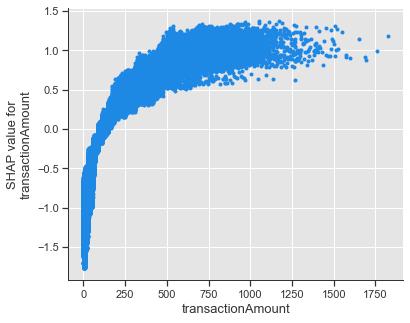

In [108]:
shap.dependence_plot("transactionAmount"
                     , shap_values
                     , build_x.loc[:, final_red_ls]
                     , interaction_index=None)

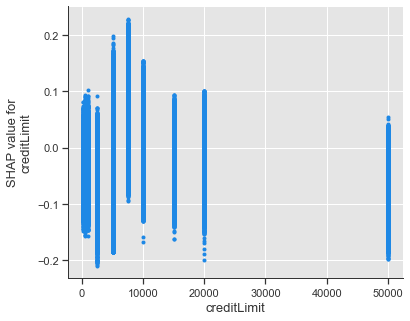

In [109]:
shap.dependence_plot("creditLimit"
                     , shap_values
                     , build_x.loc[:, final_red_ls]
                     , interaction_index=None)

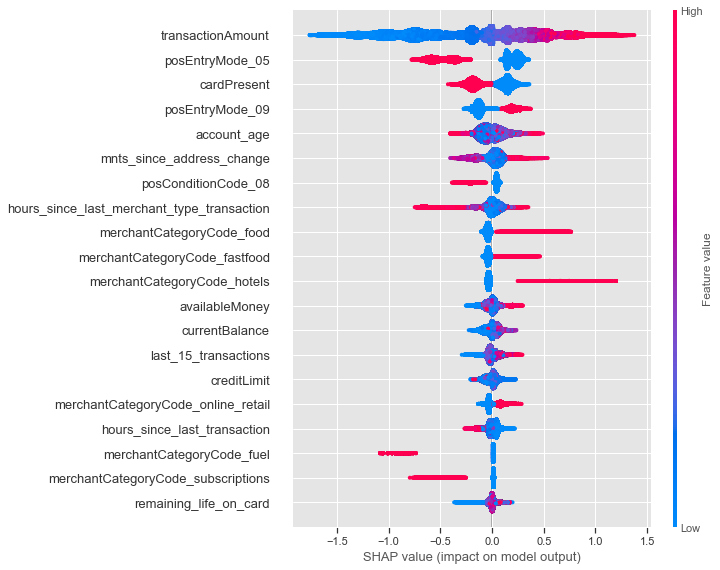

In [110]:
shap.summary_plot(shap_values, features = build_x.loc[:,final_red_ls]
                  , feature_names = build_x.loc[:,final_red_ls].columns)

# Section 5: Evaluation

In [111]:
# predict
test_Ddata = xgboost.DMatrix(test_x.loc[:,final_red_ls]
                             , test_y)

preds = xgb_.predict(test_Ddata)

In [112]:
test_x['preds'] = preds
test_x['dollarsRisk'] = test_x['preds']*test_x['transactionAmount']

## ROC - AUC Analysis

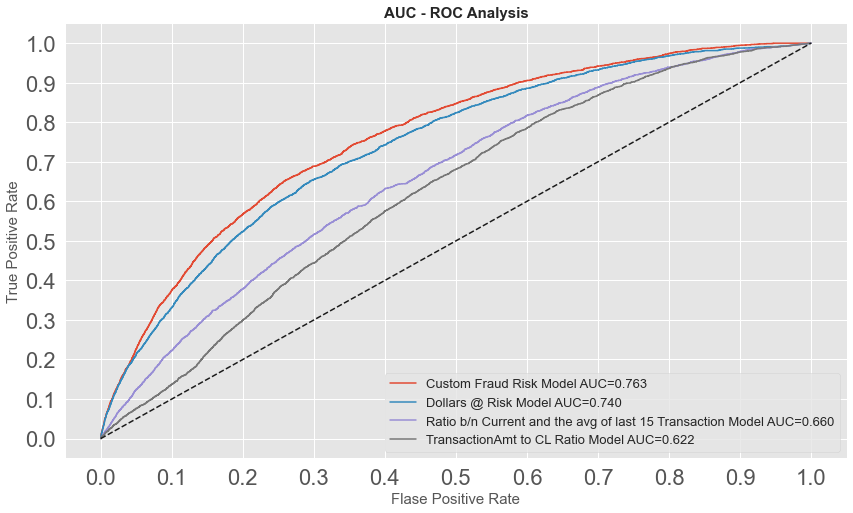

In [113]:
# TODO: Automae to recursively graph AUC and decile badRate charts
# AUC-ROC    
## graphing auc roc curve
fig = plt.figure(figsize=(14,8))
auc_ = round(roc_auc_score(test_y, preds),3)
fpr, tpr, _ = roc_curve(test_y, preds)
plt.plot(fpr
         , tpr
         , label="Custom Fraud Risk Model AUC={:.3f}".format(auc_))

auc_ = round(roc_auc_score(test_y, test_x['dollarsRisk']),3)
fpr, tpr, _ = roc_curve(test_y, test_x['dollarsRisk'])
plt.plot(fpr
         , tpr
         , label="Dollars @ Risk Model AUC={:.3f}".format(auc_))

auc_ = round(roc_auc_score(test_y, test_x['last_15_transactions']),3)
fpr, tpr, _ = roc_curve(test_y, test_x['last_15_transactions'])
plt.plot(fpr
         , tpr
         , label="Ratio b/n Current and the avg of last 15 Transaction Model AUC={:.3f}".format(auc_))

auc_ = round(roc_auc_score(test_y, test_x['transaction_CL_ratio']),3)
fpr, tpr, _ = roc_curve(test_y, test_x['transaction_CL_ratio'])
plt.plot(fpr
         , tpr
         , label="TransactionAmt to CL Ratio Model AUC={:.3f}".format(auc_))

plt.plot(fpr
         , fpr
         , 'k--')
  
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
    
plt.title('AUC - ROC Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

## Fraud Rate by Decile Sloping

In [114]:
test_x['decile'] = pd.cut(test_x['preds']
                          , ntile_list
                          , labels = range(10))

test_x['decile_spendOverAvg'] = pd.cut(test_x['last_15_transactions']
                                       , ntile_list_spendOverAvg
                                       , labels = range(10))

test_x['decile_spend_CL_ratio'] = pd.cut(test_x['transaction_CL_ratio']
                                         , ntile_list_spend_CL_ratio
                                         , labels = range(10))

test_x['decile_dollarsRisk'] = pd.cut(test_x['dollarsRisk']
                                      , ntile_list_dollarRisk
                                      , labels = range(10))

In [115]:
test_x['FraudRate'] = test_y
# calculate the fraud rates by deciles for each model
decile_dist = test_x.loc[:,['decile','FraudRate']].groupby('decile').mean().reset_index()
decile_dist_spendOverAvg = test_x.loc[:,['decile_spendOverAvg','FraudRate']].groupby('decile_spendOverAvg').mean().reset_index()
decile_dist_spend_CL_ratio = test_x.loc[:,['decile_spend_CL_ratio','FraudRate']].groupby('decile_spend_CL_ratio').mean().reset_index()
decile_dist_dollarsRisk = test_x.loc[:,['decile_dollarsRisk','FraudRate']].groupby('decile_dollarsRisk').mean().reset_index()

# collect results in a single dataframe for plotting
decile_dist['FraudRate'] = 100*decile_dist['FraudRate']
decile_dist['Ratio b/n current and the average of last 15 transactions Model'] = decile_dist_spendOverAvg['FraudRate']*100
decile_dist['TransactionAmt to CL ratio Model'] = decile_dist_spend_CL_ratio['FraudRate']*100
decile_dist['Dollars @ Risk'] = decile_dist_dollarsRisk['FraudRate']*100
decile_dist.columns = ['Decile','Custom Fraud Risk Model','Ratio b/n current and the average of last 15 transactions Model','TransactionAmt to CL ratio Model', 'Dollars @ Risk']

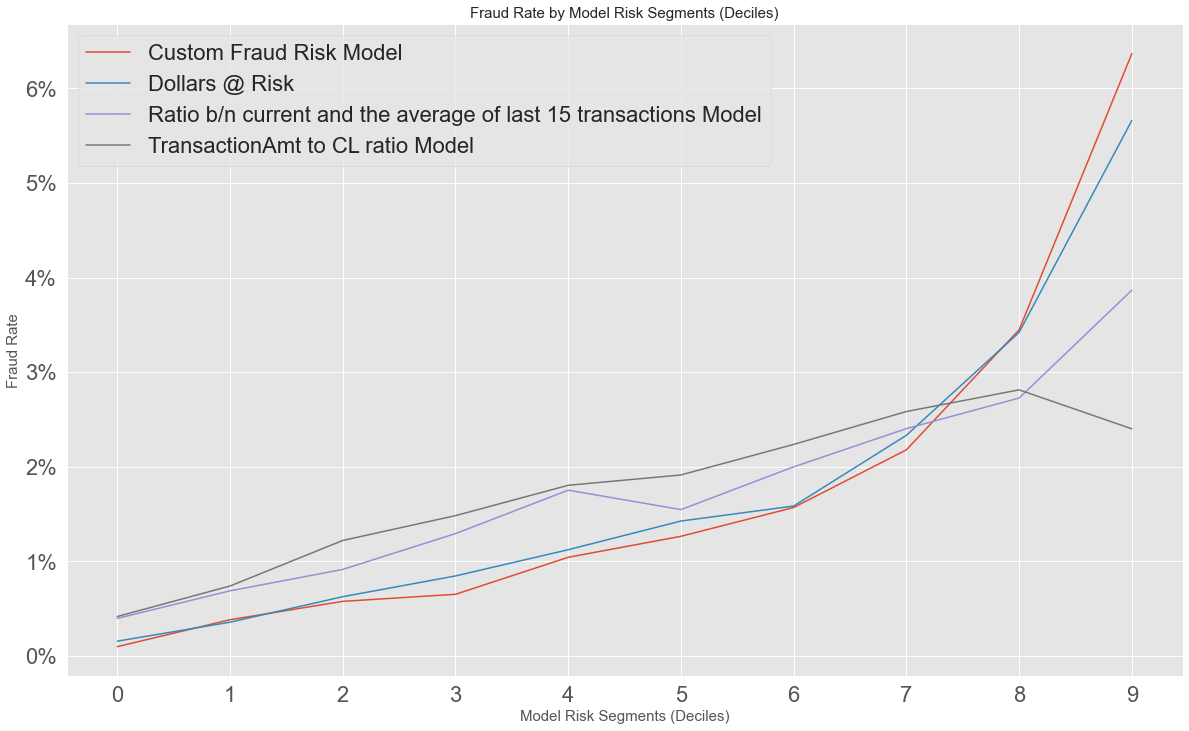

In [116]:
## plotting
ax = decile_dist.plot(x='Decile', y=['Custom Fraud Risk Model'
                                , 'Dollars @ Risk'
                                , 'Ratio b/n current and the average of last 15 transactions Model'
                                , 'TransactionAmt to CL ratio Model'
                                     
                               ]
                 , figsize=(20,12)
                 , grid=True)

plt.xticks(decile_dist['Decile'], range(10))
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title('Fraud Rate by Model Risk Segments (Deciles)', fontsize=15)
plt.xlabel("Model Risk Segments (Deciles)", fontsize=15)
plt.ylabel("Fraud Rate", fontsize=15)

plt.show()

## Cumulative Fraud Dollar loss by deciles

In [117]:
test_fraud = test_x.copy()
## clip to keep fraud transactions only!
test_fraud['isFraud'] = test_y
test_fraud = test_fraud[test_fraud['isFraud']==1]

In [118]:
## how many transactions in data are fraud?
print(test_fraud.shape[0])
## how many dollars were lost to fraud transactions?
print(test_fraud['transactionAmount'].sum())

2826
651397.5


In [119]:
# dollar losses by deciles
del decile_dist
decile_dist = test_fraud.loc[:,['decile','transactionAmount']].groupby('decile').sum().reset_index()
decile_dist_spendOverAvg = test_fraud.loc[:,['decile_spendOverAvg','transactionAmount']].groupby('decile_spendOverAvg').sum().reset_index()
decile_dist_spend_CL_ratio = test_fraud.loc[:,['decile_spend_CL_ratio','transactionAmount']].groupby('decile_spend_CL_ratio').sum().reset_index()
decile_dist_dollarsRisk = test_fraud.loc[:,['decile_dollarsRisk','transactionAmount']].groupby('decile_dollarsRisk').sum().reset_index()

decile_dist['spendOverAvg_Model'] = decile_dist_spendOverAvg['transactionAmount']
decile_dist['spend_CL_ratio_Model'] = decile_dist_spend_CL_ratio['transactionAmount']
decile_dist['dollarsRisk'] = decile_dist_dollarsRisk['transactionAmount']

decile_dist.columns = ['Decile','Custom Fraud Risk Model'
                       ,'Ratio b/n current and the average of last 15 transactions Model'
                       ,'TransactionAmt to CL ratio Model'
                       , 'Dollars @ Risk']

In [120]:
## sort the dataframe with the deciles reversed
decile_dist = decile_dist.sort_values('Decile', ascending = False)
for col in ['Custom Fraud Risk Model', 'Ratio b/n current and the average of last 15 transactions Model','TransactionAmt to CL ratio Model', 'Dollars @ Risk']:
    decile_dist[col] = decile_dist[col]/decile_dist[col].sum()
    decile_dist[col] = 100*decile_dist[col].cumsum()
decile_dist

,Decile,Custom Fraud Risk Model,Ratio b/n current and the average of last 15 transactions Model,TransactionAmt to CL ratio Model,Dollars @ Risk
9,9,56.455392,44.135630,21.675751,59.423424
8,8,74.355669,63.890136,46.229975,78.425458
7,7,83.715498,76.248039,64.601772,87.926866
6,6,89.574937,86.555337,77.329541,93.160089
5,5,94.119130,91.477786,85.875885,96.439160
4,4,97.321044,96.135899,92.837547,98.454705
3,3,98.616997,98.490832,96.895648,99.429468
2,2,99.574948,99.564793,99.079123,99.863168
1,1,99.941408,99.945034,99.911292,99.990881
0,0,100.000000,100.000000,100.000000,100.000000


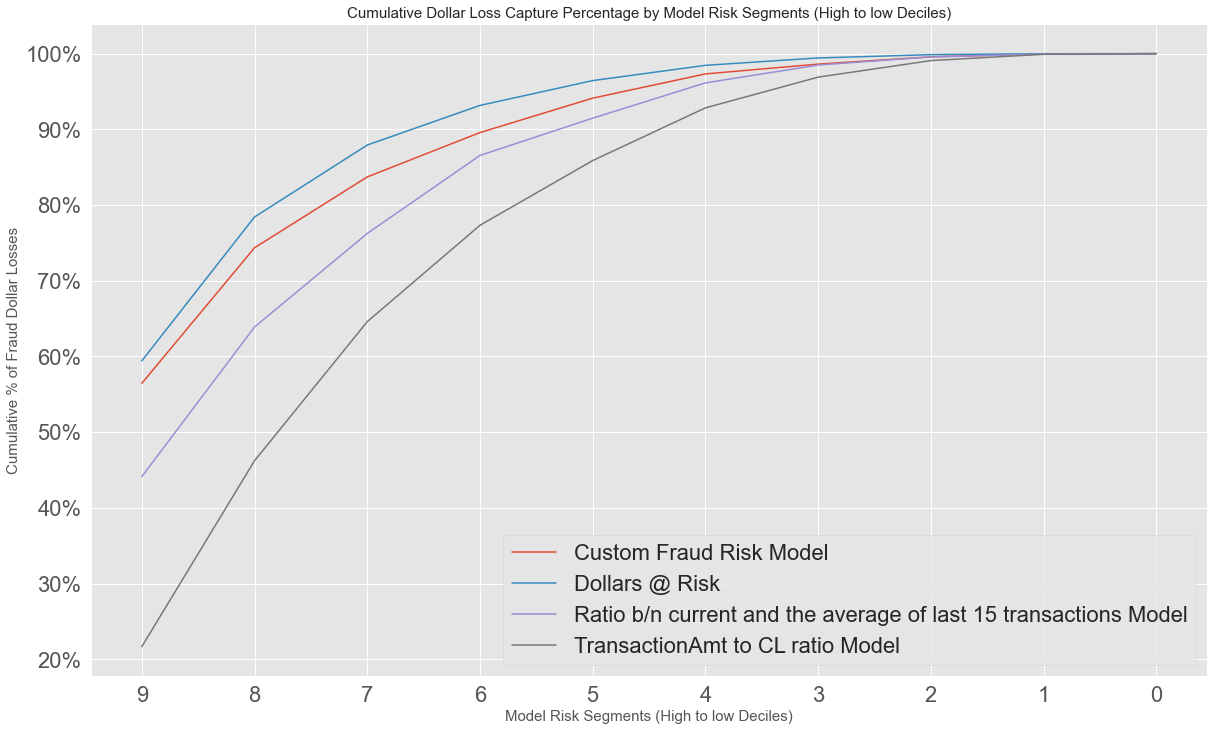

In [121]:
ax = decile_dist.plot(x='Decile', y=['Custom Fraud Risk Model'
                                , 'Dollars @ Risk'
                                , 'Ratio b/n current and the average of last 15 transactions Model'
                                , 'TransactionAmt to CL ratio Model'
                               ]
                 , figsize=(20,12)
                 , grid=True)
plt.xticks(decile_dist['Decile'], range(10))
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title('Cumulative Dollar Loss Capture Percentage by Model Risk Segments (High to low Deciles)', fontsize=15)
plt.xlabel("Model Risk Segments (High to low Deciles)", fontsize=15)
plt.ylabel("Cumulative % of Fraud Dollar Losses", fontsize=15)
plt.show()

In [122]:
"""fig = plt.figure(figsize = (10,6))
sns.barplot(x='decile', y='FraudRate', data=decile_dist
           , palette = "flare")
plt.xlabel('Model Deciles')
plt.ylabel('Fraud Percentage %')
plt.xticks(rotation=90)
plt.show()"""

'fig = plt.figure(figsize = (10,6))\nsns.barplot(x=\'decile\', y=\'FraudRate\', data=decile_dist\n           , palette = "flare")\nplt.xlabel(\'Model Deciles\')\nplt.ylabel(\'Fraud Percentage %\')\nplt.xticks(rotation=90)\nplt.show()'

In [123]:
""""delta = 30
spendAvg = 'avg_transactions_in_last_'+str(delta)+'_days'
df1 = df.loc[:, ['customerId','cardLast4Digits','transactionDateTime', 'transactionAmount']].copy()
df[spendAvg]= (df1.set_index('transactionDateTime'
                            ).groupby(['customerId', 'cardLast4Digits']
                                     ).rolling(f'{delta}D'
                                              ).mean()
              ).reset_index(level=[0,1], drop=True
                           ).reset_index()['transactionAmount']
del df1
# create spend over avergae
spendOverAvg = 'spend_over_'+spendAvg
df[spendOverAvg] = (df['transactionAmount']/df[spendAvg]).fillna(0)

fig = plt.figure(figsize = (10,6))
sns.barplot(x='N-tile buckets', y='isFraud', data=ntile_dist(df, spendOverAvg,'isFraud', ntile=10).sort_index()
           , palette = "flare")
plt.xlabel('Spend Over Average')
plt.ylabel('Fraud Percentage %')
plt.ylim((0,5))
plt.xticks(rotation=90)
plt.show()"""

'"delta = 30\nspendAvg = \'avg_transactions_in_last_\'+str(delta)+\'_days\'\ndf1 = df.loc[:, [\'customerId\',\'cardLast4Digits\',\'transactionDateTime\', \'transactionAmount\']].copy()\ndf[spendAvg]= (df1.set_index(\'transactionDateTime\'\n                            ).groupby([\'customerId\', \'cardLast4Digits\']\n                                     ).rolling(f\'{delta}D\'\n                                              ).mean()\n              ).reset_index(level=[0,1], drop=True\n                           ).reset_index()[\'transactionAmount\']\ndel df1\n# create spend over avergae\nspendOverAvg = \'spend_over_\'+spendAvg\ndf[spendOverAvg] = (df[\'transactionAmount\']/df[spendAvg]).fillna(0)\n\nfig = plt.figure(figsize = (10,6))\nsns.barplot(x=\'N-tile buckets\', y=\'isFraud\', data=ntile_dist(df, spendOverAvg,\'isFraud\', ntile=10).sort_index()\n           , palette = "flare")\nplt.xlabel(\'Spend Over Average\')\nplt.ylabel(\'Fraud Percentage %\')\nplt.ylim((0,5))\nplt.xticks(rotati